In [1]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import glob
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings


warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code

# session lists in a .py file
# import sessionlists
%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/test.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/sequencesALLDATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 26 rats in the data folder


In [34]:
rat_markers = {}
params = {}
nb_runsBin = {}
speedRunToLeftBin, speedRunToRightBin = {}, {}
timeRunToLeftBin, timeRunToRightBin = {}, {}
maxSpeedLeftBin, maxSpeedRightBin = {}, {}
timeStayInLeftBin, timeStayInRightBin = {}, {}
totalDistance, totalWater, total_trials = {}, {}, {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}
instantSpeedLeftBin, instantSpeedRightBin = {}, {}
trackTimeToLeftBin, trackTimeToRightBin = {}, {}
sequence = {}

# # define colors for each rat
# palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
#            'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
#            'RatF20': (0.4, 0.0, 0.0), 'RatF21': (0.55, 0.13, 0.13), 'RatF22': (0.8, 0.2, 0.2),
#            'RatM20': (0.0, 0.4, 0.0), 'RatM21': (0.13, 0.55, 0.13), 'RatM22': (0.2, 0.8, 0.2),
#            'RatF30': (0.4, 0.0, 0.0), 'RatF31': (0.55, 0.13, 0.13), 'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
#            'RatM30': (0.0, 0.4, 0.0), 'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
#            'RatF30L': (0.4, 0.0, 0.0), 'RatF31L': (0.55, 0.13, 0.13), 'RatF32L': (0.8, 0.2, 0.2), 'RatF33L': (0.8, 0.2, 0.2),
#            'RatM30L': (0.0, 0.4, 0.0), 'RatM31L': (0.13, 0.55, 0.13), 'RatM32L': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal'}

intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')

# markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
# lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}

# RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 's', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
                                                #  dist60bis+dist90bis+dist120bis)):

        # get the preprocessed data from the pickle file
        # In this notebook we only need the sequence of events, so we only load that
        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

        params[animal, session]     = get_from_pickle(root, animal[0:6], session, name="params.p", biglesion=biglesion)
        nb_runsBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="nbRuns.p", biglesion=biglesion)
        speedRunToLeftBin[animal, session],  speedRunToRightBin[animal, session]  = get_from_pickle(root, animal[0:6], session, name="avgSpeed.p", biglesion=biglesion)
        maxSpeedLeftBin[animal, session],    maxSpeedRightBin[animal, session]    = get_from_pickle(root, animal[0:6], session, name="maxSpeed.p", biglesion=biglesion)
        timeStayInLeftBin[animal, session],  timeStayInRightBin[animal, session]  = get_from_pickle(root, animal[0:6], session, name="timeinZone.p", biglesion=biglesion)
        timeRunToLeftBin[animal, session],   timeRunToRightBin[animal, session]   = get_from_pickle(root, animal[0:6], session, name="timeRun.p", biglesion=biglesion)
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="trackPos.p", biglesion=biglesion)
        instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal[0:6], session, name="trackSpeed.p", biglesion=biglesion)
        trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal[0:6], session, name="trackTime.p", biglesion=biglesion)
        totalDistance[animal, session],      totalWater[animal, session], total_trials[animal, session] = get_from_pickle(root, animal[0:6], session, name="misc.p", biglesion=biglesion)


Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43


In [49]:

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 's', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43


In [4]:
# separate the data into time and reward bins for each experimental condition
# distances 
data60IDLE = prepare_data_idle_times(sequence, animalList, dist60)
data90IDLE = prepare_data_idle_times(sequence, animalList, dist90)
data120IDLE = prepare_data_idle_times(sequence, animalList, dist120)

data60RUN = prepare_data_running_times(sequence, animalList, dist60)
data90RUN = prepare_data_running_times(sequence, animalList, dist90)
data120RUN = prepare_data_running_times(sequence, animalList, dist120)

# treadmill speeds
data20IDLE = prepare_data_idle_times(sequence, animalList, TM20)
data10IDLE = prepare_data_idle_times(sequence, animalList, TM10)
data2IDLE = prepare_data_idle_times(sequence, animalList, TM2+TMrev2)
datarev10IDLE = prepare_data_idle_times(sequence, animalList, TMrev10)
datarev20IDLE = prepare_data_idle_times(sequence, animalList, TMrev20)

data20RUN = prepare_data_running_times(sequence, animalList, TM20)
data10RUN = prepare_data_running_times(sequence, animalList, TM10)
data2RUN = prepare_data_running_times(sequence, animalList, TM2+TMrev2)
datarev10RUN = prepare_data_running_times(sequence, animalList, TMrev10)
datarev20RUN = prepare_data_running_times(sequence, animalList, TMrev20)

# all conditions pooled
dataAllIDLE = prepare_data_idle_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)
dataAllRUN = prepare_data_running_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)

def Ri_color(score):
    if score < 0.7:
        return 'r'
    elif score < 0.8:
        return 'orange'
    elif score < 0.9:
        return 'g'
    else:
        raise ValueError(f'Invalid value for the Ri score: {score}')

def intact_vs_lesion_Zscore(ax, num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=14, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = ax.get_ylim()
    # dh *= (ax_y1 - ax_y0)
    # barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = (y+dh, (lx+rx)/2)

    ax.plot(bary, barx, c='black')

    # kwargs = dict(ha='center', va='bottom')
    # if fs is not None:
    #     kwargs['fontsize'] = fs

    ax.text(*mid, text,
    #  **kwargs, 
     rotation=-90, fontsize=fs)

In [5]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 
            'RatF42', 'RatM40', 'RatM43']

In [6]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']

In [328]:

alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, False, False, False

alpha, gamma, alpha_t, gamma_t, alpha_R, gamma_R, lossWald = {}, {}, {}, {}, {}, {}, {}
mu, mu_t, mu_R, sigma, sigma_t, sigma_R, loss = {}, {}, {}, {}, {}, {}, {}


def modelrun_fit(data, init=[1, 1, 1, 1, 1, 1], f=modelrun_crit,
                 N_bins=6, N_avg=4, N_params=2,
                 mu_t_fixed=False, sigma_t_fixed=False,
                 mu_R_fixed=False, sigma_R_fixed=False):
    params_init = np.array(init)
    mu_t_bounds = (None, None) if not mu_t_fixed else (0, 1e-8)
    sigma_t_bounds = (None, None) if not sigma_t_fixed else (0, 1e-8)
    mu_R_bounds = (None, None) if not mu_R_fixed else (0, 1e-8)
    sigma_R_bounds = (None, None) if not sigma_R_fixed else (0, 1e-8)

    res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params),
                   bounds=((None, None), (None, None),
                           mu_t_bounds, sigma_t_bounds,
                           mu_R_bounds, sigma_R_bounds))
    return res.x, res.fun


for animal in animalList:
    alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

    mu[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    mu_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    mu_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    loss[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60IDLE, data90IDLE, data120IDLE, data20IDLE, data10IDLE, data2IDLE, datarev10IDLE, datarev20IDLE]):
        (alpha[animal][cond], theta, gamma[animal][cond], \
        alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
        alpha_R[animal][cond], thetasecond, gamma_R[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                        gamma_t_fixed=gamma_t_fixed, 
                                                                                                                        alpha_R_fixed=alpha_R_fixed, 
                                                                                                                        gamma_R_fixed=gamma_R_fixed)

    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60RUN, data90RUN, data120RUN, data20RUN, data10RUN, data2RUN, datarev10RUN, datarev20RUN]):
        (mu[animal][cond], sigma[animal][cond], \
        mu_t[animal][cond], sigma_t[animal][cond], \
        mu_R[animal][cond], sigma_R[animal][cond]), loss[animal][cond] = modelrun_fit(data[animal], mu_t_fixed=mu_t_fixed, 
                                                                                                    sigma_t_fixed=sigma_t_fixed, 
                                                                                                    mu_R_fixed=mu_R_fixed, 
                                                                                                    sigma_R_fixed=sigma_R_fixed,)



In [7]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']
# pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R,], open("picklejar/intact_lesionFITS.p", "wb"))
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))


# animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
#             'RatF32', 'RatF33', 'RatM31', 'RatM32', 
#             'RatF42', 'RatM40', 'RatM43']
# pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R,], open("picklejar/intactFITS.p", "wb"))
# alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intactFITS.p", "rb"))

# zscore on intact

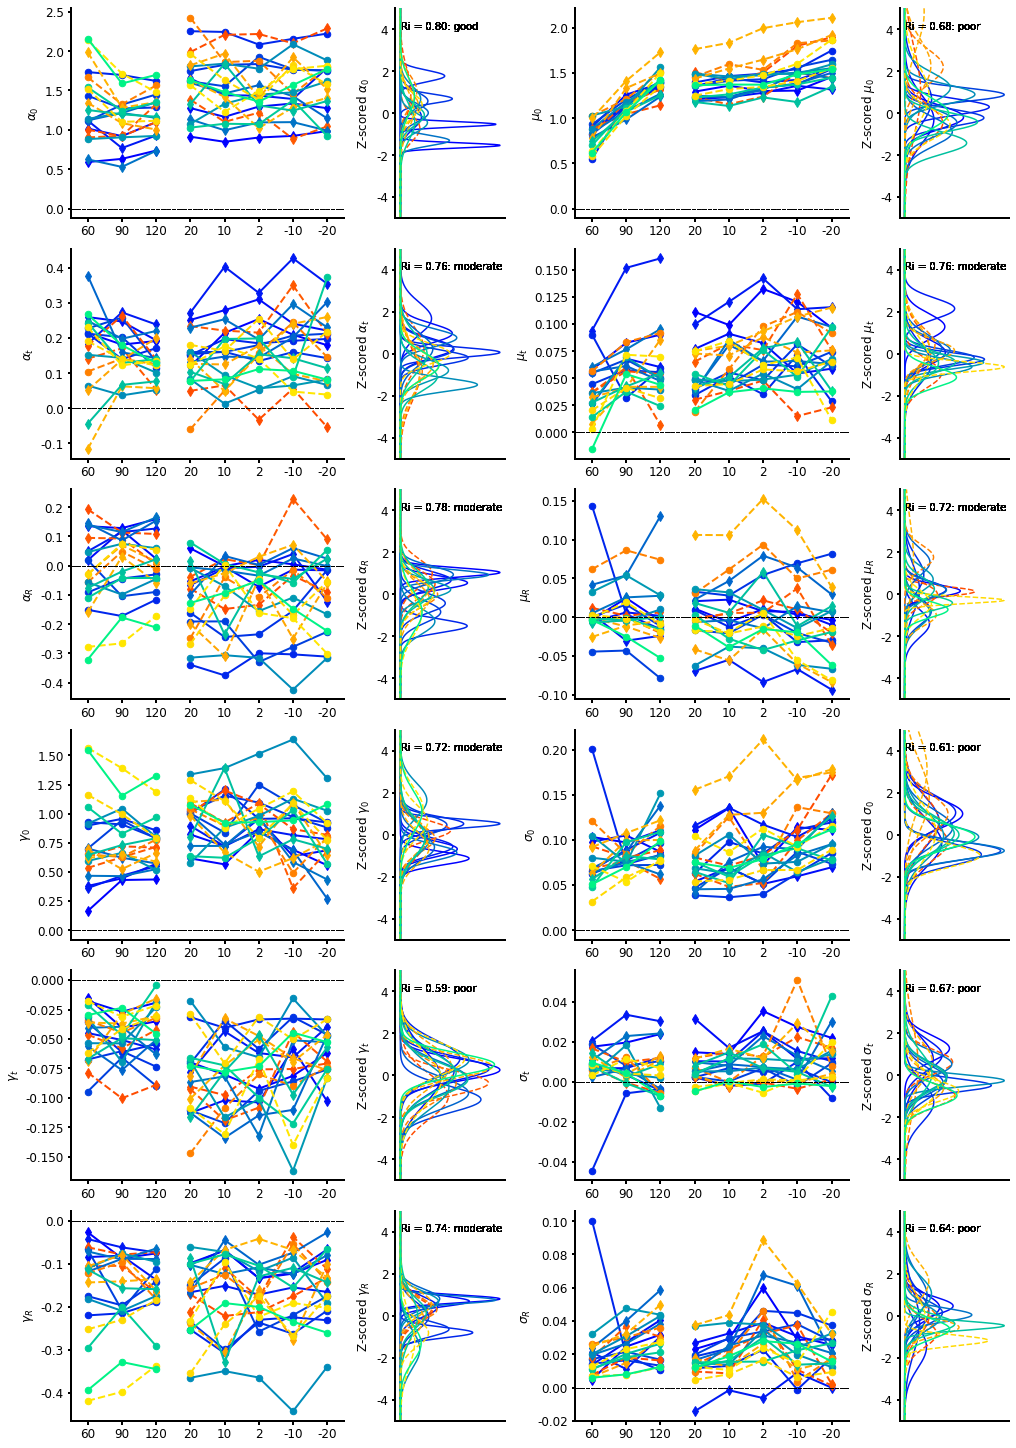

In [332]:
fig, axs = plt.subplots(6, 4, figsize=(14, 20), gridspec_kw={'width_ratios': [5, 2, 5, 2]})
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylimsIDLE = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .15], [-.05, .2], [-.05, .05], [-.025, .1], ]

varsIDLE = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
varsRUN = [mu, mu_t, mu_R, sigma, sigma_t, sigma_R, ]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        # x, y = np.arange(8), [var[animal]["60"], var[animal]["90"], var[animal]["120"], var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(8))
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 7.5)
        # axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 2].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 2].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 2].set_title(f"")
        axs[i, 2].set_xticks(np.arange(8))
        axs[i, 2].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 2].set_ylabel(ylabel)
        axs[i, 2].set_xlim(-.5, 7.5)
        # axs[i, 2].set_ylim(ylim)
        axs[i, 2].axhline(0, color='black', linestyle='--', linewidth=1)
    

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']



Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in intact]))/np.std([alpha[animal][key] for animal in intact]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in intact]))/np.std([alpha_t[animal][key] for animal in intact]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in intact]))/np.std([alpha_R[animal][key] for animal in intact]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in intact]))/np.std([gamma[animal][key] for animal in intact]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in intact]))/np.std([gamma_t[animal][key] for animal in intact]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in intact]))/np.std([gamma_R[animal][key] for animal in intact]) for key in gamma_R[animal]} for animal in animalList}

traitsIDLE = {animal: [] for animal in animalList}
ZvarsIDLE = [Zalpha, Zalpha_t, Zalpha_R, Zgamma, Zgamma_t, Zgamma_R]
for j, zvar in enumerate(ZvarsIDLE):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        pdf = stats.norm.pdf(np.linspace(-5, 5, 600), np.mean(zscores), np.std(zscores))
        traitsIDLE[animal].append(np.mean(zscores))
        axs[j, 1].plot(pdf, np.linspace(-5, 5, 600), color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
        Ri = compute_Ri(zvar, intact)
        axs[j, 1].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
        axs[j, 1].set_ylim(-5, 5)
        axs[j, 1].set_ylabel("Z-scored " + ylabelsIDLE[j])
        axs[j, 1].set_xlabel("")
        axs[j, 1].set_xticks([])



Zmu = {animal: {key: (mu[animal][key] - np.mean([mu[animal][key] for animal in intact]))/np.std([mu[animal][key] for animal in intact]) for key in mu[animal]} for animal in animalList}
Zmu_t = {animal: {key: (mu_t[animal][key] - np.mean([mu_t[animal][key] for animal in intact]))/np.std([mu_t[animal][key] for animal in intact]) for key in mu_t[animal]} for animal in animalList}
Zmu_R = {animal: {key: (mu_R[animal][key] - np.mean([mu_R[animal][key] for animal in intact]))/np.std([mu_R[animal][key] for animal in intact]) for key in mu_R[animal]} for animal in animalList}
Zsigma = {animal: {key: (sigma[animal][key] - np.mean([sigma[animal][key] for animal in intact]))/np.std([sigma[animal][key] for animal in intact]) for key in sigma[animal]} for animal in animalList}
Zsigma_t = {animal: {key: (sigma_t[animal][key] - np.mean([sigma_t[animal][key] for animal in intact]))/np.std([sigma_t[animal][key] for animal in intact]) for key in sigma_t[animal]} for animal in animalList}
Zsigma_R = {animal: {key: (sigma_R[animal][key] - np.mean([sigma_R[animal][key] for animal in intact]))/np.std([sigma_R[animal][key] for animal in intact]) for key in sigma_R[animal]} for animal in animalList}

traitsRUN = {animal: [] for animal in animalList}
ZvarsRUN = [Zmu, Zmu_t, Zmu_R, Zsigma, Zsigma_t, Zsigma_R]
for j, zvar in enumerate(ZvarsRUN):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        pdf = stats.norm.pdf(np.linspace(-5, 5, 600), np.mean(zscores), np.std(zscores))
        traitsRUN[animal].append(np.mean(zscores))
        axs[j, 3].plot(pdf, np.linspace(-5, 5, 600), color=rat_markers[animal][0], linestyle=rat_markers[animal][2])
        Ri = compute_Ri(zvar, intact)
        axs[j, 3].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
        axs[j, 3].set_ylim(-5, 5)
        axs[j, 3].set_ylabel("Z-scored " + ylabelsRUN[j])
        axs[j, 3].set_xlabel("")
        axs[j, 3].set_xticks([])

In [333]:

for i in range(len(traitsIDLE[animal])):
    allIntact = []
    allLesion = []
    for animal in animalList:
        if brainstatus[animal] == "normal":
            allIntact.append(traitsIDLE[animal][i])
        else:
            allLesion.append(traitsIDLE[animal][i])
    print(i, exact_mc_perm_test(allIntact, allLesion))



for i in range(len(traitsRUN[animal])):
    allIntact = []
    allLesion = []
    for animal in animalList:
        if brainstatus[animal] == "normal":
            allIntact.append(traitsRUN[animal][i])
        else:
            allLesion.append(traitsRUN[animal][i])
    print(i, exact_mc_perm_test(allIntact, allLesion))

0 0.2862
1 0.1597
2 0.841
3 0.7019
4 0.8973
5 0.8012
0 0.0156
1 0.7862
2 0.5367
3 0.1018
4 0.6074
5 0.6494


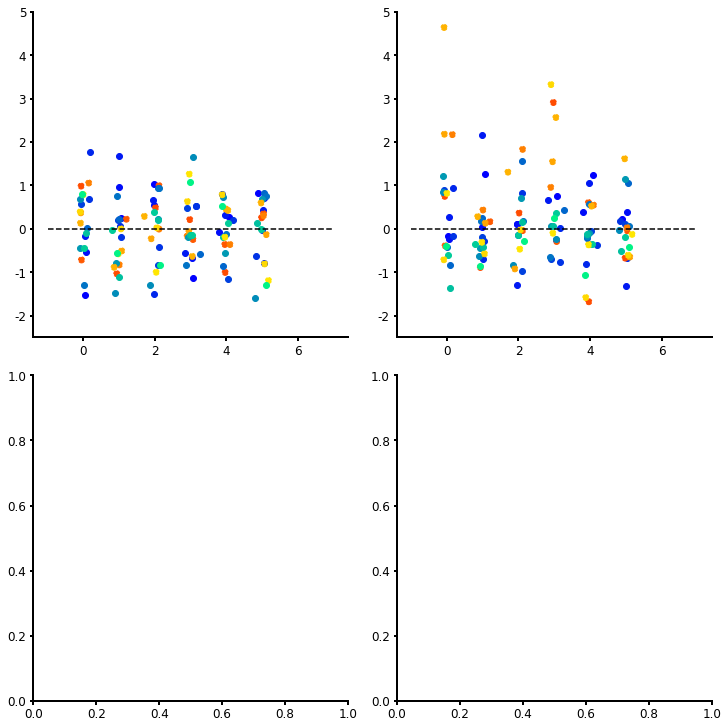

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), )
# for j, zvar in enumerate(traitsIDLE):
for animal in animalList:
    # if 'M' in animal:
    x = np.arange(len(traitsIDLE[animal])) + np.random.normal(0, 0.1, len(traitsIDLE[animal]))
    axs[0, 0].scatter(x, traitsIDLE[animal], color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
    axs[0, 1].scatter(x, traitsRUN[animal], color=rat_markers[animal][0], linestyle=rat_markers[animal][2])

    # else:
        # axs[1, 0].scatter(np.arange(len(traitsIDLE[animal])), traitsIDLE[animal], color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
        # axs[1, 1].scatter(np.arange(len(traitsRUN[animal])), traitsRUN[animal], color=rat_markers[animal][0], linestyle=rat_markers[animal][2])
axs[0, 0].set_ylim(-2.5, 5)
axs[0, 1].set_ylim(-2.5, 5)
axs[0, 0].plot([-1, 7], [0, 0], color='black', linestyle='--')
axs[0, 1].plot([-1, 7], [0, 0], color='black', linestyle='--')




for j, zvar in enumerate(ZvarsIDLE):
    allIntact = []
    allLesion = []
    for animal in animalList:
        
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        # print(animal, zscores)
        if brainstatus[animal] == "normal":
            allIntact.extend(zscores)
            shift=0
        else:
            allLesion.extend(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[0, 0].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
    
    perm = exact_mc_perm_test(allIntact, allLesion)
    print("idle", j, perm)
    if perm < 0.05:
        axs[0, 0].annotate("*", xy=(j, 3), xycoords='data', fontsize=30)

for j, zvar in enumerate(ZvarsRUN):
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        if brainstatus[animal] == "normal":
            allIntact.append(zscores)
            shift=0
        else:
            allLesion.append(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[0, 1].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])

    perm = exact_mc_perm_test(allIntact, allLesion)
    print("run", j, perm)
    if perm < 0.05:
        axs[0, 1].annotate("*", xy=(j, 4.5), xycoords='data', fontsize=30)

idle 0 0.0106
idle 1 0.0028
idle 2 0.6215
idle 3 0.3925
idle 4 0.8272
idle 5 0.5777
run 0 0.0263
run 1 0.7679
run 2 0.4544
run 3 0.0014
run 4 0.3793
run 5 0.8445


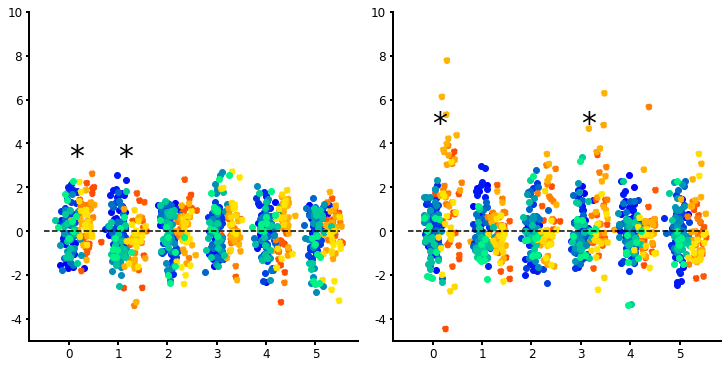

In [225]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), )

axs[0].set_ylim(-5, 10)
axs[1].set_ylim(-5, 10)
axs[0].plot([-.5, 5.5], [0, 0], color='black', linestyle='--')
axs[1].plot([-.5, 5.5], [0, 0], color='black', linestyle='--')

for j, zvar in enumerate(ZvarsIDLE):
    allIntact = []
    allLesion = []
    for animal in animalList:
        
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        # print(animal, zscores)
        if brainstatus[animal] == "normal":
            allIntact.extend(zscores)
            shift=0
        else:
            allLesion.extend(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[0].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
    
    perm = exact_mc_perm_test(allIntact, allLesion)
    print("idle", j, perm)
    if perm < 0.05:
        axs[0].annotate("*", xy=(j, 3), xycoords='data', fontsize=30)

for j, zvar in enumerate(ZvarsRUN):
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        if brainstatus[animal] == "normal":
            allIntact.append(zscores)
            shift=0
        else:
            allLesion.append(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[1].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])

    perm = exact_mc_perm_test(allIntact, allLesion)
    print("run", j, perm)
    if perm < 0.05:
        axs[1].annotate("*", xy=(j, 4.5), xycoords='data', fontsize=30)


In [21]:
intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF32', 'RatF33', 'RatM31', 'RatM32', 
              'RatF42', 'RatM40', 'RatM43'
              ]

$\alpha_0$ corr: 0.56, p: 0.0487
$\alpha_t$ corr: -0.67, p: 0.0119
$\alpha_R$ corr: -0.75, p: 0.0033
$\gamma_0$ corr: 0.81, p: 0.0007
$\gamma_t$ corr: 0.21, p: 0.4839
$\gamma_R$ corr: -0.71, p: 0.0061
$\mu_0$ corr: 0.59, p: 0.0340
$\mu_t$ corr: -0.67, p: 0.0115
$\mu_R$ corr: -0.01, p: 0.9625
$\sigma_0$ corr: -0.43, p: 0.1376
$\sigma_t$ corr: -0.61, p: 0.0257
$\sigma_R$ corr: 0.23, p: 0.4422


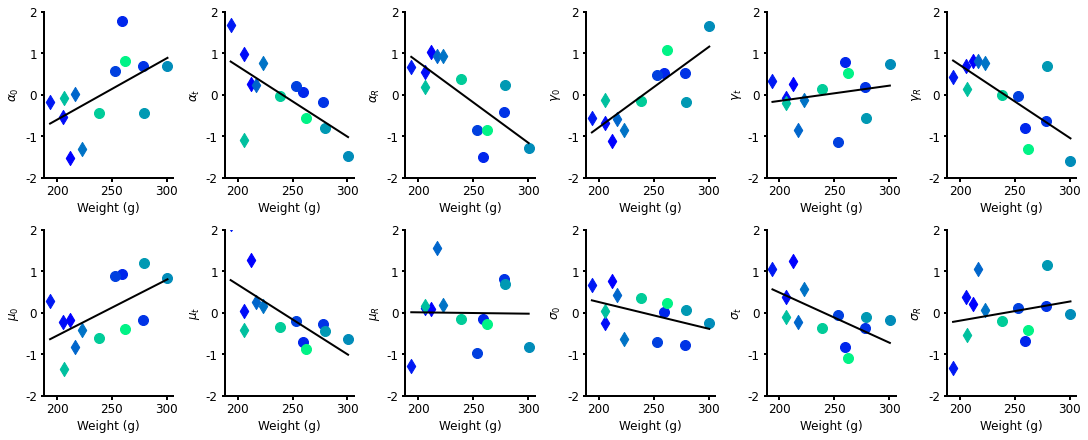

In [252]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            # 'RatF20': 220.10, 'RatF21': 215.53, 'RatF22': 215.0,
            # 'RatM20': 254.68, 'RatM21': 307.29, 'RatM22': 330.53,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            # 'RatF30L': 217.32, 'RatF31L': 228.95, 'RatF32L': 216.80, 'RatF33L': 222.77,
            # 'RatM30L': 261.38, 'RatM31L': 300.55, 'RatM32L': 279.23
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}

fig, ax = plt.subplots(2, 6, figsize=(15, 6))
for j, zvar in enumerate(ZvarsIDLE):
    _x, _y = [], []
    for animal in intact:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = np.mean(zscores)
        x = weights[animal]

        ax[0, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[0, j].set_xlabel("Weight (g)")
        ax[0, j].set_ylabel(ylabelsIDLE[j])
        ax[0, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsIDLE[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[0, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

for j, zvar in enumerate(ZvarsRUN):
    _x, _y = [], []
    for animal in intact:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = np.mean(zscores)
        x = weights[animal]

        ax[1, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[1, j].set_xlabel("Weight (g)")
        ax[1, j].set_ylabel(ylabelsRUN[j])
        ax[1, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsRUN[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[1, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

In [5]:
_map = plt.cm.get_cmap('jet')

for index, animal in enumerate(animalList):

    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[_map(index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[_map(index/len(animalList)), 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32


# behav

In [6]:

# plot variable median/mean fir each blockFdodger
def plot_median_per_bin(data, rewardProbaBlock, blocks, barplotaxes, color, stat,
                        xyLabels=[" ", " ", " ", " "], title="", scatter=False, ax=None):
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250, label="%reward: " + str(rewardProbaBlock[i]) if (i == 0 or i == 1) else "")
        if scatter:
            ax.scatter(np.random.normal(((blocks[i][1] + blocks[i][0])/120), 1, len(data[i])), data[i], s=5, color=color[0])

    if stat == "Avg. ":
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], [np.mean(data[i]) for i in range(0, len(blocks))], marker='o', ms=7, linewidth=2, color=color[0])
        if isinstance(data[0], list):
            ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], [np.mean(data[i]) for i in range(0, len(blocks))], yerr=[stats.sem(data[i]) for i in range(0, len(blocks))], fmt='o', color=color[0], ecolor='black', elinewidth=1, capsize=0);

    elif stat == "Med. ":
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], [np.median(data[i]) for i in range(0, len(blocks))], marker='o', ms=7, linewidth=2, color=color[0])
        if isinstance(data[0], list):
            ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], [np.median(data[i]) for i in range(0, len(blocks))], yerr=[stats.sem(data[i]) for i in range(0, len(blocks))], fmt='o', color=color[0], ecolor='black', elinewidth=1, capsize=3);

    ax.set_title(title)
    ax.set_xlabel(xyLabels[0])
    ax.set_ylabel("Average " + xyLabels[1], color=color[0])
    ax.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax.set_ylim([barplotaxes[2], barplotaxes[3]])
    return ax

def across_session_plot(plot, animal_list, session_list, dataLeft, dataRight, experiment, params, plot_axes, ticks, titles_plot_xaxis_yaxis, datatype, marker, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set_title(titles_plot_xaxis_yaxis[0], fontsize=16)
    ax.set_xlabel(titles_plot_xaxis_yaxis[1], fontsize=16)
    ax.set_ylabel(titles_plot_xaxis_yaxis[2], fontsize=16)
    ax.set_xlim(plot_axes[0], plot_axes[1])
    ax.set_ylim(plot_axes[2], plot_axes[3])
    if ticks[0] != []:
        ax.set_xticks(ticks[0])
    if ticks[1] != []:
        ax.set_yticks(ticks[1])
    ax.tick_params(width=1.5, labelsize=12)
    # if experiment == 'TM_ON': ax.tick_params(axis = 'x', rotation = 45)
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.yaxis.set_label_coords(-0.22, 0.5)
    ax.patch.set_facecolor('grey')
    ax.patch.set_alpha(90/250 if plot == "90%" else
                       10/250 if plot == "10%" else
                       0)
    ax.yaxis.label.set_color('cyan' if datatype == 'avgrunspeed' else
                             'dodgerblue' if datatype == 'runningtime' else
                             'orange' if datatype == 'idletime' else
                             'red'if datatype == 'maxspeed' else 'k')

    a, b, c, d, e, f, g, h, i, j, k, l = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    LW = 1
    if experiment == 'Distance':
        data90_60, data90_90, data90_120, data10_60, data10_90, data10_120 = separate_data(animal_list, session_list, dataLeft, dataRight, experiment, params, datatype, False)
        for animal in animal_list:
            # if datatype == 'runningtime':
            realdist60, realdist90, realdist120 = ticks[2]
            x = (np.nanmean(realdist60[animal]), np.nanmean(realdist90[animal]), np.nanmean(realdist120[animal]))
            ax.set_xticks([int(np.nanmean([np.nanmean(realdist60[animal]) for animal in animal_list])),
                            int(np.nanmean([np.nanmean(realdist90[animal]) for animal in animal_list])),
                            int(np.nanmean([np.nanmean(realdist120[animal]) for animal in animal_list]))])
            ax.set_xlim(plot_axes[0], plot_axes[1])

            # else:
            #     x = (60, 90, 120)

            if datatype == 'nb_runs':
                a = np.mean(data90_60[animal])
                b = np.mean(data90_90[animal])
                c = np.mean(data90_120[animal])
                d = np.mean(data10_60[animal])
                e = np.mean(data10_90[animal])
                f = np.mean(data10_120[animal])
            else:
                a = np.nanmean([item for sublist in data90_60[animal] for item in sublist])
                b = np.nanmean([item for sublist in data90_90[animal] for item in sublist])
                c = np.nanmean([item for sublist in data90_120[animal] for item in sublist])
                d = np.nanmean([item for sublist in data10_60[animal] for item in sublist])
                e = np.nanmean([item for sublist in data10_90[animal] for item in sublist])
                f = np.nanmean([item for sublist in data10_120[animal] for item in sublist])

            if plot == "90%":
                ax.plot(x, (a, b, c), marker=marker[animal][1], markersize=6, linestyle=marker[animal][2], linewidth=LW, color=marker[animal][0])
                # ax.errorbar(x, (a, b, c), yerr = (stats.std([item for sublist in data90_60[animal]  for item in sublist]),  stats.std([item for sublist in data90_90[animal]  for item in sublist]), stats.std([item for sublist in data90_120[animal] for item in sublist])), color = marker[animal][0], linestyle=marker[animal][2])
            if plot == "10%":
                ax.plot(x, (d, e, f), marker=marker[animal][1], markersize=6, linestyle=marker[animal][2], linewidth=LW, color=marker[animal][0])
                # ax.errorbar(x, (d, e, f), yerr = (stats.std([item for sublist in data10_60[animal]  for item in sublist]),  stats.std([item for sublist in data10_90[animal]  for item in sublist]), stats.std([item for sublist in data10_120[animal] for item in sublist])), color = marker[animal][0], linestyle=marker[animal][2])
            if plot == "%":
                ax.plot(x, (d/a, e/b, f/c), marker=marker[animal][1], markersize=6, linestyle=marker[animal][2], linewidth=LW, color=marker[animal][0])

    if experiment == 'TM_ON':
        data90_rev20, data90_rev10, data90_rev2, data90_2, data90_10, data90_20, data10_rev20, data10_rev10, data10_rev2, data10_2, data10_10, data10_20 = separate_data(animal_list, session_list, dataLeft, dataRight, experiment, params, datatype, False)
        for animal in animal_list:
            x = (-20, -10, -2, 2, 10, 20)
            if datatype == 'nb_runs':
                a = np.mean(data90_rev20[animal])
                b = np.mean(data90_rev10[animal])
                c = np.mean(data90_rev2[animal])
                d = np.mean(data90_2[animal])
                e = np.mean(data90_10[animal])
                f = np.mean(data90_20[animal])

                g = np.mean(data10_rev20[animal])
                h = np.mean(data10_rev10[animal])
                i = np.mean(data10_rev2[animal])
                j = np.mean(data10_2[animal])
                k = np.mean(data10_10[animal])
                l = np.mean(data10_20[animal])
            else:
                a = np.nanmean([item for sublist in data90_rev20[animal] for item in sublist])
                b = np.nanmean([item for sublist in data90_rev10[animal] for item in sublist])
                c = np.nanmean([item for sublist in data90_rev2[animal] for item in sublist])
                d = np.nanmean([item for sublist in data90_2[animal] for item in sublist])
                e = np.nanmean([item for sublist in data90_10[animal] for item in sublist])
                f = np.nanmean([item for sublist in data90_20[animal] for item in sublist])

                g = np.nanmean([item for sublist in data10_rev20[animal] for item in sublist])
                h = np.nanmean([item for sublist in data10_rev10[animal] for item in sublist])
                i = np.nanmean([item for sublist in data10_rev2[animal] for item in sublist])
                j = np.nanmean([item for sublist in data10_2[animal] for item in sublist])
                k = np.nanmean([item for sublist in data10_10[animal] for item in sublist])
                l = np.nanmean([item for sublist in data10_20[animal] for item in sublist])

            if plot == "90%":
                ax.plot(x, (a, b, c, d, e, f), marker=marker[animal][1], markersize=6, linestyle=marker[animal][2], linewidth=LW, color=marker[animal][0])
            if plot == "10%":
                ax.plot(x, (g, h, i, j, k, l), marker=marker[animal][1], markersize=6, linestyle=marker[animal][2], linewidth=LW, color=marker[animal][0])
            if plot == "%":
                ax.plot(x, (g/a, h/b, i/c, j/d, k/e, l/f), marker=marker[animal][1], markersize=6, linestyle=marker[animal][2], linewidth=LW, color=marker[animal][0])
    return ax


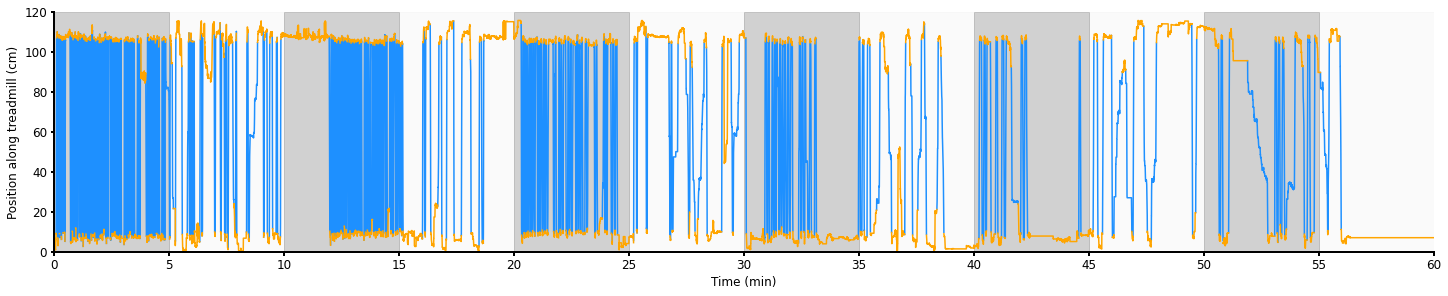

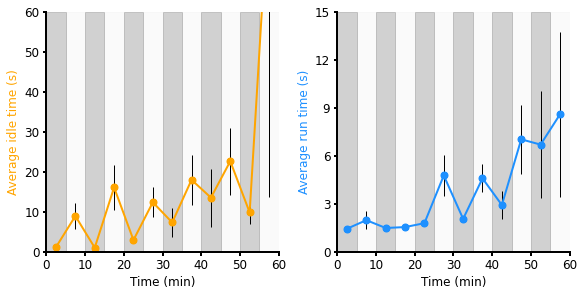

In [7]:

animal, session = 'RatM01', 'RatM01_2021_07_22_17_14_48'  # 'RatF00', 'RatF00_2021_07_24_15_28_05'
animal, session = 'RatF02', 'RatF02_2021_07_22_18_14_16'
example_params = get_from_pickle(root, animal, session, name="params.p")
example_nbRuns = get_from_pickle(root, animal, session, name="nbRuns.p")
example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
example_avgspeedToLeftBin, example_avgspeedToRightBin = get_from_pickle(root, animal, session, name="avgSpeed.p")
example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")



fig, axs = plt.subplots(1, figsize = (20, 4))
# plot the trajectory
plot_animal_trajectory(root=root, animal=animal, session=session, params=example_params, barplotaxes=[0, 3600, 0, 120], 
                 xyLabels=["Time (min)", "Position along treadmill (cm)"], title="Position of example animal across a 120 cm session", ax=axs)


scat = False
stat ='Avg. '
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
# plot_median_per_bin([example_nbRuns[i]/5 for i in range(0, 12)], 
# example_params['rewardProbaBlock'], example_params['blocks'], barplotaxes = [0, 3600/60, 0, 25], 
# color = ['k'], xyLabels=["Time (min)", "\u0023 runs / min"], title="", stat='Med. ', ax=axs[0]);

plot_median_per_bin([example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)], 
                example_params['rewardProbaBlock'], example_params['blocks'], barplotaxes=[0, 3600/60, 0, 60], 
                color=['orange'], xyLabels=["Time (min)","idle time (s)"], title="", scatter=scat, stat=stat, ax=axs[0]);

# # plot the median running time in each time block
# plot_median_per_bin([example_avgspeedToLeftBin[i]+example_avgspeedToRightBin[i] for i in range(0, 12)], 
#                 example_params['rewardProbaBlock'], example_params['blocks'], barplotaxes=[0, 3600/60, 0, 100], 
#                 color=['cyan'], xyLabels=["Time (min)","running time (s)"], title="", scatter=scat, stat='Med. ', ax=axs[2]);

# plot the median running time in each time block
plot_median_per_bin([example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)], 
                example_params['rewardProbaBlock'], example_params['blocks'], barplotaxes=[0, 3600/60, 0., 15], 
                color=['dodgerblue'], xyLabels=["Time (min)","run time (s)"], title="", scatter=scat, stat=stat, ax=axs[1]);
axs[1].set_yticks([0, 3, 6, 9, 12, 15])

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (13).

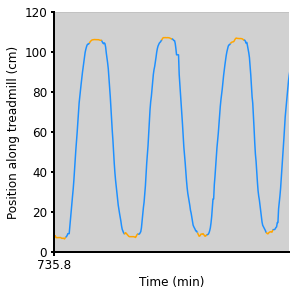

In [8]:
fig, axs = plt.subplots(1, figsize = (4, 4))
# plot the trajectory
plot_animal_trajectory(root=root, animal=animal, session=session, params=example_params, barplotaxes=[735.8, 750, 0, 120], 
                 xyLabels=["Time (min)", "Position along treadmill (cm)"], title="Position of example animal across a 120 cm session", ax=axs)


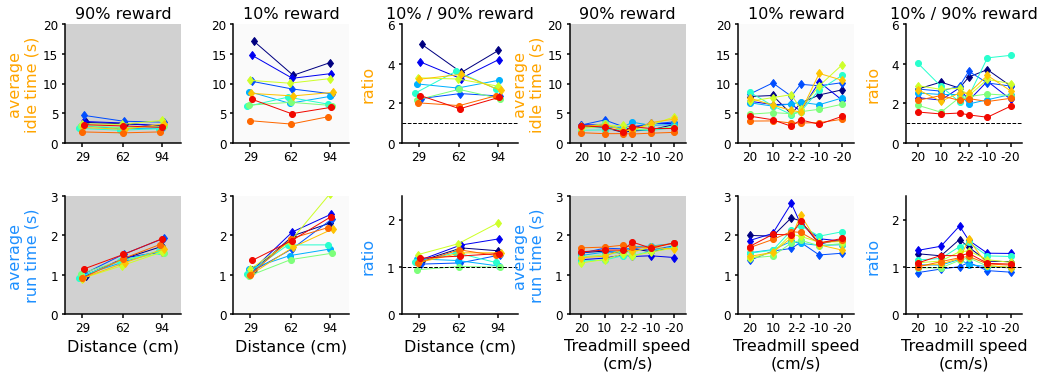

In [10]:
#TAC plots
fig = plt.figure(constrained_layout = False, figsize=(30.5, 13)) #10, 14
fig.suptitle("", y=0.9, fontsize = 24)
gs = fig.add_gridspec(29, 71)

row1 = slice(0, 5)
row2 = slice(7, 12)
row3 = slice(14, 19)
row4 = slice(21, 26)

col1 = slice(0, 5)
col2 = slice(7, 12)
col3 = slice(14, 19)
col4 = slice(21, 26)
col5 = slice(28, 33)
col6 = slice(35, 40)

# compute true run distance
realdist60 = {}
realdist90 = {}
realdist120= {}

# compute the running distance for each run (pos start - pos end) for each distance configuration
for animal in animalList:
    realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
    for session in sorted(matchsession(animal, dist60)):
        for i in range(0, 12):
            realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist90)):   
        for i in range(0, 12):
            realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist120)):
        for i in range(0, 12):
            realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])



session_list = dist60+dist90+dist120
experiment = 'Distance'

ax10 = fig.add_subplot(gs[row1, col1])
ax10 = across_session_plot("90%", animalList, session_list, timeStayInLeftBin, timeStayInRightBin, experiment, params, plot_axes = [15, 110, 0, 20], ticks = [[60, 90, 120],[0, 5, 10, 15, 20], [realdist60, realdist90, realdist120]], titles_plot_xaxis_yaxis = ['90% reward', '', 'average\nidle time (s)'], datatype = 'idletime', marker=rat_markers)
# ax10.set_xticklabels(['S', 'M', 'L'])
ax11 = fig.add_subplot(gs[row1, col2])
ax11 = across_session_plot("10%", animalList, session_list, timeStayInLeftBin, timeStayInRightBin, experiment, params, plot_axes = [15, 110, 0, 20], ticks = [[60, 90, 120],[0, 5, 10, 15, 20], [realdist60, realdist90, realdist120]], titles_plot_xaxis_yaxis = ['10% reward', '', ''], datatype = 'idletime', marker=rat_markers)
# ax11.set_xticklabels(['S', 'M', 'L'])
ax12 = fig.add_subplot(gs[row1, col3])
ax12 = across_session_plot("%",   animalList, session_list, timeStayInLeftBin, timeStayInRightBin, experiment, params, plot_axes = [15, 110, 0, 6], ticks = [[60, 90, 120],[0, 2, 4, 6], [realdist60, realdist90, realdist120]], titles_plot_xaxis_yaxis = ['10% / 90% reward', '', 'ratio'], datatype = 'idletime', marker=rat_markers)
ax12.axhline(y=1, color='k', linestyle='--', linewidth=1)
# ax12.set_xticklabels(['S', 'M', 'L'])

ax30 = fig.add_subplot(gs[row2, col1])
ax30 = across_session_plot("90%", animalList, session_list, timeRunToLeftBin, timeRunToRightBin, experiment, params, plot_axes = [15, 110, 0, 3], ticks = [[60, 90, 120],[0, 1, 2, 3], [realdist60, realdist90, realdist120]], titles_plot_xaxis_yaxis = ['', 'Distance (cm)', 'average\nrun time (s)'], datatype = 'runningtime', marker=rat_markers)
# ax30.set_xticklabels(['S', 'M', 'L'])
ax31 = fig.add_subplot(gs[row2, col2])
ax31 = across_session_plot("10%", animalList, session_list, timeRunToLeftBin, timeRunToRightBin, experiment, params, plot_axes = [15, 110, 0, 3], ticks = [[60, 90, 120],[0, 1, 2, 3], [realdist60, realdist90, realdist120]], titles_plot_xaxis_yaxis = ['', 'Distance (cm)', ''], datatype = 'runningtime', marker=rat_markers)
# ax31.set_xticklabels(['S', 'M', 'L'])
ax32 = fig.add_subplot(gs[row2, col3])
ax32 = across_session_plot("%",   animalList, session_list, timeRunToLeftBin, timeRunToRightBin, experiment, params, plot_axes = [15, 110, 0, 2.5], ticks = [[60, 90, 120],[0, 1, 2], [realdist60, realdist90, realdist120]], titles_plot_xaxis_yaxis = ['', 'Distance (cm)', 'ratio'], datatype = 'runningtime', marker=rat_markers)
ax32.axhline(y=1, color='k', linestyle='--', linewidth=1)
# ax32.set_xticklabels(['S', 'M', 'L'])

session_list = TM20+TM10+TM2+TMrev2+TMrev10+TMrev20
experiment = 'TM_ON'

ax10 = fig.add_subplot(gs[row1, col4])
ax10 = across_session_plot("90%", animalList, session_list, timeStayInLeftBin, timeStayInRightBin, experiment, params, plot_axes = [25, -25, 0, 20], ticks = [[-20, -10, -2, 2, 10, 20],[0, 5, 10, 15, 20]], titles_plot_xaxis_yaxis = ['90% reward', '', 'average\nidle time (s)'], datatype = 'idletime', marker=rat_markers)
ax11 = fig.add_subplot(gs[row1, col5])
ax11 = across_session_plot("10%", animalList, session_list, timeStayInLeftBin, timeStayInRightBin, experiment, params, plot_axes = [25, -25, 0, 20], ticks = [[-20, -10, -2, 2, 10, 20],[0, 5, 10, 15, 20]], titles_plot_xaxis_yaxis = ['10% reward', '', ''], datatype = 'idletime', marker=rat_markers)
ax12 = fig.add_subplot(gs[row1, col6])
ax12 = across_session_plot("%",   animalList, session_list, timeStayInLeftBin, timeStayInRightBin, experiment, params, plot_axes = [25, -25, 0, 6], ticks = [[-20, -10, -2, 2, 10, 20],[0, 2, 4, 6]], titles_plot_xaxis_yaxis = ['10% / 90% reward', '', 'ratio'], datatype = 'idletime', marker=rat_markers)
ax12.axhline(y=1, color='k', linestyle='--', linewidth=1)

ax30 = fig.add_subplot(gs[row2, col4])
ax30 = across_session_plot("90%", animalList, session_list, timeRunToLeftBin, timeRunToRightBin, experiment, params, plot_axes = [25, -25, 0, 3], ticks = [[-20, -10, -2, 2, 10, 20],[0, 1, 2, 3]], titles_plot_xaxis_yaxis = ['', 'Treadmill speed\n(cm/s)', 'average\nrun time (s)'], datatype = 'runningtime', marker=rat_markers)
ax31 = fig.add_subplot(gs[row2, col5])
ax31 = across_session_plot("10%", animalList, session_list, timeRunToLeftBin, timeRunToRightBin, experiment, params, plot_axes = [25, -25, 0, 3], ticks = [[-20, -10, -2, 2, 10, 20],[0, 1, 2, 3]], titles_plot_xaxis_yaxis = ['', 'Treadmill speed\n(cm/s)', ''], datatype = 'runningtime', marker=rat_markers)
ax32 = fig.add_subplot(gs[row2, col6])
ax32 = across_session_plot("%",   animalList, session_list, timeRunToLeftBin, timeRunToRightBin, experiment, params, plot_axes = [25, -25, 0, 2.5], ticks = [[-20, -10, -2, 2, 10, 20],[0, 1, 2]], titles_plot_xaxis_yaxis = ['', 'Treadmill speed\n(cm/s)', 'ratio'], datatype = 'runningtime', marker=rat_markers)
ax32.axhline(y=1, color='k', linestyle='--', linewidth=1)

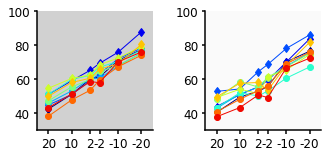

In [14]:
#TAC plots speed
fig = plt.figure(constrained_layout = False, figsize=(30.5, 13)) #10, 14
fig.suptitle("", y=0.9, fontsize = 24)
gs = fig.add_gridspec(29, 71)

row1 = slice(0, 5)
row2 = slice(7, 12)
row3 = slice(14, 19)
row4 = slice(21, 26)

col1 = slice(0, 5)
col2 = slice(7, 12)
col3 = slice(14, 19)
col4 = slice(21, 26)
col5 = slice(28, 33)
col6 = slice(35, 40)

# compute true run distance
realdist60 = {}
realdist90 = {}
realdist120= {}

# compute the running distance for each run (pos start - pos end) for each distance configuration
for animal in animalList:
    realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
    for session in sorted(matchsession(animal, dist60)):
        for i in range(0, 12):
            realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist90)):   
        for i in range(0, 12):
            realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist120)):
        for i in range(0, 12):
            realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])



session_list = TM20+TM10+TM2+TMrev2+TMrev10+TMrev20
experiment = 'TM_ON'


ax20 = fig.add_subplot(gs[row3, col4])
ax20 = across_session_plot("90%", animalList, session_list, speedRunToLeftBin, speedRunToRightBin, experiment, params, plot_axes = [25, -25, 30, 100], ticks = [[-20, -10, -2, 2, 10, 20],[]], titles_plot_xaxis_yaxis = ['', '', ''], datatype = 'avgrunspeed', marker=rat_markers)
ax21 = fig.add_subplot(gs[row3, col5])
ax21 = across_session_plot("10%", animalList, session_list, speedRunToLeftBin, speedRunToRightBin, experiment, params, plot_axes = [25, -25, 30, 100], ticks = [[-20, -10, -2, 2, 10, 20],[]], titles_plot_xaxis_yaxis = ['', '', ''], datatype = 'avgrunspeed', marker=rat_markers)


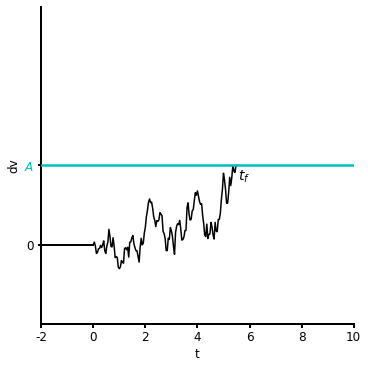

In [ ]:
std = 1
t0 = 2
N = 100
def plot_DDMexample1(mean, std, A, t0, N=100, title=''):
    """plot example of DDM with specified parameters"""

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv
        if len(y) > 5*25 and example_plot:
            ax.plot(x, y, c='k', lw=1.5, zorder=4)
            ax.annotate(r'$t_f$', (len(y)/25, A-2), (0, 1), xycoords="data", textcoords="offset points", color="k", zorder=4, fontsize=14)
            example_plot = False
        # ax.plot(x, y, c='orange', alpha=.5, zorder=3)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    ax.axhline(A, c='c', zorder=5, lw=2.5)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$A$'])
    ax.get_yticklabels()[1].set_color('c')
    ax.set_xlabel('t')
    ax.set_ylabel('dv')
    ax.set_title(title)
    ax.set_ylim(-10, 30)
    ax.set_xlim(-2, 10)
    ax.plot((0, -t0), (0, 0), zorder=5, lw=2, c='k')
    plt.savefig('dv.png', transparent=True, dpi=300)

plot_DDMexample1(.25, std, 10, t0, N=N, title="")

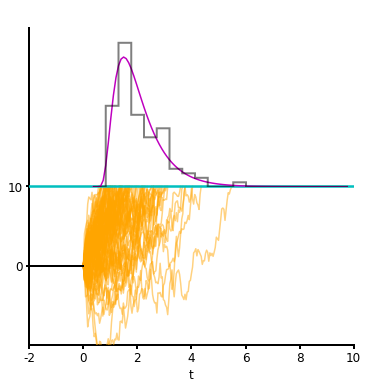

In [ ]:
std = 1
t0 = 2
N = 100
def plot_DDMexample2(mean, std, A, t0, N=100, title=''):
    """plot example of DDM with specified parameters"""

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv

        ax.plot(x, y, c='orange', alpha=.5, zorder=3)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c='c', zorder=5, lw=2.5)
    ax.set_yticks([0, A])

    ax.set_xlabel('t')

    ax.set_title(title)
    ax.set_ylim(-10, 30)
    ax.set_xlim(-2, 10)
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=2)
    plt.savefig('DDMparams1.png', transparent=True, dpi=300)


        # inset distribution
    l, b, h, w = 0.105, .55, .5, .85
    ax1 = fig.add_axes([l, b, w, h])
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax1.hist(waits, bins=bins, color='k',
             alpha=.5, zorder=4, histtype="step", lw=2,
             # cumulative=1,
             density=True,
             weights=np.ones_like(waits) / len(waits),
             )
    ax1.set_ylim(0, 0.8)
    ax1.set_xlim(-2, 10)
    ax1.set_ylabel('PDF')
    ax1.axis('off')

    # inset

    plt.savefig('DDM1.png', transparent=True, dpi=300)



    p, _ = wald_fit(waits)
    x = np.linspace(0, 1000, 10000)
    ax1.plot(x, Wald_pdf(x, *p), 'm-', label='Default')
    plt.savefig('DDMwald.png', transparent=True, dpi=300)




plot_DDMexample2(.25, std, 10, t0, N=N, title="")

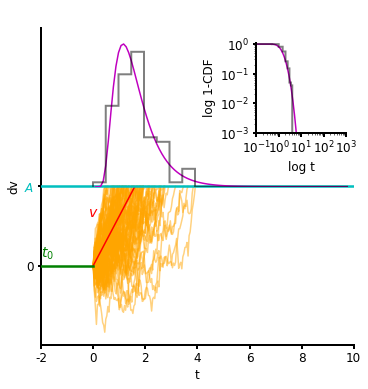

In [ ]:
def plot_DDMexample3(mean, std, A, t0, N=100, title=''):
    """plot example of DDM with specified parameters"""

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv
        if len(y) > 5*25 and example_plot:
            ax.plot(x, y, c='k', lw=1.5, zorder=4)
            ax.annotate(r'$t_f$', (len(y)/25, A-2), (0, 1), xycoords="data", textcoords="offset points", color="k", zorder=4, fontsize=14)
            example_plot = False
        ax.plot(x, y, c='orange', alpha=.5, zorder=3)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.plot(np.linspace(0, waitmean/25, int(waitmean)+1), A / waitmean * np.arange(waitmean), c="r", zorder=4)
    ax.annotate(r'$v$', ((waitmean/25)/2-1, (A/2)+1), (0, 1), xycoords="data", textcoords="offset points", color="r", zorder=4, fontsize=14)
    # ax.spines['left'].set_position(('data', t0))
    # ax.axhline(0, xmin=t0, c="k", ls="--", zorder=5, lw=2.5)
    ax.axhline(A, c='c', zorder=5, lw=2.5)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$A$'])
    ax.get_yticklabels()[1].set_color('c')
    ax.set_xlabel('t')
    ax.set_ylabel('dv')
    ax.set_title(title)
    ax.set_ylim(-10, 30)
    ax.set_xlim(-2, 10)
    ax.plot((0, -t0), (0, 0), c="g", zorder=5, lw=2.5)
    ax.annotate(r'$t_0$', ((0-t0), 1), (0, 0), xycoords="data", textcoords="offset points", color="g", zorder=4, fontsize=14)

    # inset distribution
    l, b, h, w = 0.105, .55, .5, .85
    ax1 = fig.add_axes([l, b, w, h])
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax1.hist(waits, bins=bins, color='k',
             alpha=.5, zorder=4, histtype="step", lw=2,
             # cumulative=1,
             density=True,
             weights=np.ones_like(waits) / len(waits),
             )
    p, _ = wald_fit(waits)
    x = np.linspace(0, 1000, 10000)
    ax1.plot(x, Wald_pdf(x, *p), 'm-', label='Default')
    ax1.set_ylim(0, 0.8)
    ax1.set_xlim(-2, 10)
    ax1.set_ylabel('PDF')
    ax1.axis('off')

    # inset
    l, b, h, w = .7, .7, .25, .25
    ax2 = fig.add_axes([l, b, w, h])
    ax2.hist(waits, bins=bins, color='k',
             alpha=.5, zorder=4, histtype="step", lw=2,
             cumulative=-1, density=True,
             weights=np.ones_like(waits) / len(waits),
             )
    ax2.plot(x, 1-Wald_cdf(x, *p), 'm-', label='Default')
    ax2.set_ylim(0.001, 1.1)
    ax2.set_xlim(.1, 1000)
    ax2.set_ylabel('log 1-CDF')
    ax2.set_xlabel('log t')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    plt.savefig('DDM.png', transparent=True, dpi=300)


plot_DDMexample3(.25, std, 10, t0, N=N, title="")

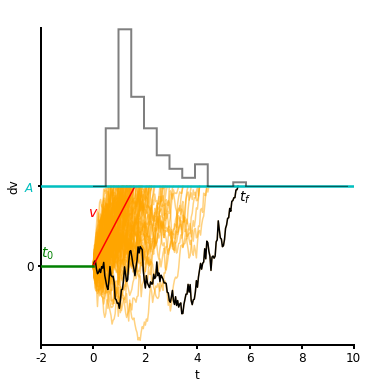

In [ ]:
def plot_DDMexample31(mean, std, A, t0, N=100, title=''):
    """plot example of DDM with specified parameters"""

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv
        if len(y) > 5*25 and example_plot:
            ax.plot(x, y, c='k', lw=1.5, zorder=4)
            ax.annotate(r'$t_f$', (len(y)/25, A-2), (0, 1), xycoords="data", textcoords="offset points", color="k", zorder=4, fontsize=14)
            example_plot = False
        ax.plot(x, y, c='orange', alpha=.5, zorder=3)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.plot(np.linspace(0, waitmean/25, int(waitmean)+1), A / waitmean * np.arange(waitmean), c="r", zorder=4)
    ax.annotate(r'$v$', ((waitmean/25)/2-1, (A/2)+1), (0, 1), xycoords="data", textcoords="offset points", color="r", zorder=4, fontsize=14)
    # ax.spines['left'].set_position(('data', t0))
    # ax.axhline(0, xmin=t0, c="k", ls="--", zorder=5, lw=2.5)
    ax.axhline(A, c='c', zorder=5, lw=2.5)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$A$'])
    ax.get_yticklabels()[1].set_color('c')
    ax.set_xlabel('t')
    ax.set_ylabel('dv')
    ax.set_title(title)
    ax.set_ylim(-10, 30)
    ax.set_xlim(-2, 10)
    ax.plot((0, -t0), (0, 0), c="g", zorder=5, lw=2.5)
    ax.annotate(r'$t_0$', ((0-t0), 1), (0, 0), xycoords="data", textcoords="offset points", color="g", zorder=4, fontsize=14)

    # inset distribution
    l, b, h, w = 0.105, .55, .5, .85
    ax1 = fig.add_axes([l, b, w, h])
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax1.hist(waits, bins=bins, color='k',
             alpha=.5, zorder=4, histtype="step", lw=2,
             # cumulative=1,
             density=True,
             weights=np.ones_like(waits) / len(waits),
             )
    ax1.set_ylim(0, 0.8)
    ax1.set_xlim(-2, 10)
    ax1.set_ylabel('PDF')
    ax1.axis('off')

    # inset

    plt.savefig('DDM1.png', transparent=True, dpi=300)


plot_DDMexample31(.25, std, 10, t0, N=N, title="")

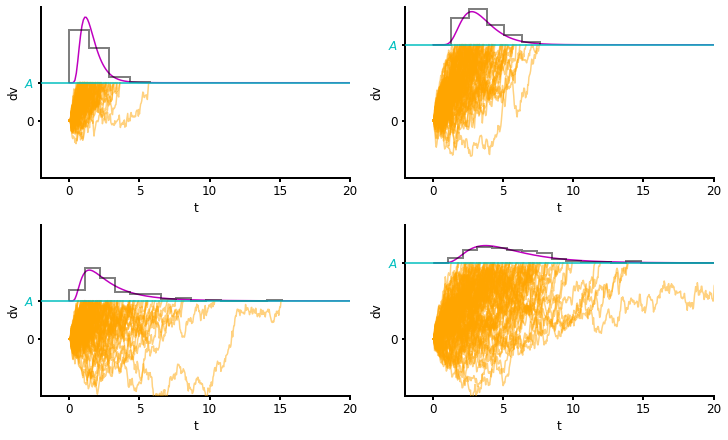

In [ ]:
std = 1
t0 = 2
N = 100
def plot_DDMexample2(mean, std, A, t0, N=100, title=''):
    """plot example of DDM with specified parameters"""

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv

        ax.plot(x, y, c='orange', alpha=.5, zorder=3)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c='c', zorder=5, lw=2.5)
    ax.set_yticks([0, A])

    ax.set_xlabel('t')

    ax.set_title(title)
    ax.set_ylim(-10, 30)
    ax.set_xlim(-2, 10)
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=2)

        # inset distribution
    l, b, h, w = 0.105, .55, .5, .85
    ax1 = fig.add_axes([l, b, w, h])
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax1.hist(waits, bins=bins, color='k',
             alpha=.5, zorder=4, histtype="step", lw=2,
             # cumulative=1,
             density=True,
             weights=np.ones_like(waits) / len(waits)*25,
             )
    ax1.set_ylim(0, 0.8)
    ax1.set_xlim(-2, 10)
    ax1.set_ylabel('PDF')
    ax1.axis('off')

    p, _ = wald_fit(waits)
    x = np.linspace(0, 1000, 10000)
    ax1.plot(x, 25*Wald_pdf(x, *p)+A, 'm-', label='Default')
    plt.savefig(f'DDM_A{A}_G{mean}.png', transparent=True, dpi=300)

def plot_DDMexampleParams1(v, A, ax=None):
    mean = v
    if ax is None:
        ax = plt.gca()
    N = 100
    t0 = 2
    std = 1
    # np.random.seed(0)
    trials = [generate_trials(mean, std, A, t0) for _ in range(N)]

    rnd = np.random.randint(0, len(trials))
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv

        ax.plot(x, y, c='orange', alpha=.5, zorder=3)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    bins = np.linspace(0, waits.max(), int(max(waits)))
    ax.hist(waits, bins=bins, color='k', bottom=A,
            alpha=.5, zorder=4, histtype="step", lw=2,
            weights=np.ones_like(waits) / len(waits)*25,
            )

    p, _ = wald_fit(waits)
    x = np.linspace(0, 1000, 10000)
    ax.plot(x, (25*Wald_pdf(x, *p))+A, 'm-', label='Default')

   
    ax.axhline(A, c='c', zorder=4)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$A$'])
    ax.get_yticklabels()[1].set_color('c')
    ax.set_xlabel('t')
    ax.set_ylabel('dv')
    ax.set_title('')
    ax.set_ylim(-15, 30)
    ax.set_xlim(-2, 20)



fig, ax = plt.subplots(2, 2, figsize=(10, 6))
plot_DDMexampleParams1(.25,  10, ax=ax[0, 0])
plot_DDMexampleParams1(.25,  20, ax=ax[0, 1])
plot_DDMexampleParams1(.15,  10, ax=ax[1, 0])
plot_DDMexampleParams1(.15,  20, ax=ax[1, 1])

# animations

In [ ]:
# same plot but interactive
pl = interact(plot_DDMexampleParams, v=(0, 2, 0.1), A=(0, 5, 0.1));

interactive(children=(FloatSlider(value=1.0, description='v', max=2.0), FloatSlider(value=2.0, description='A'…

# fit

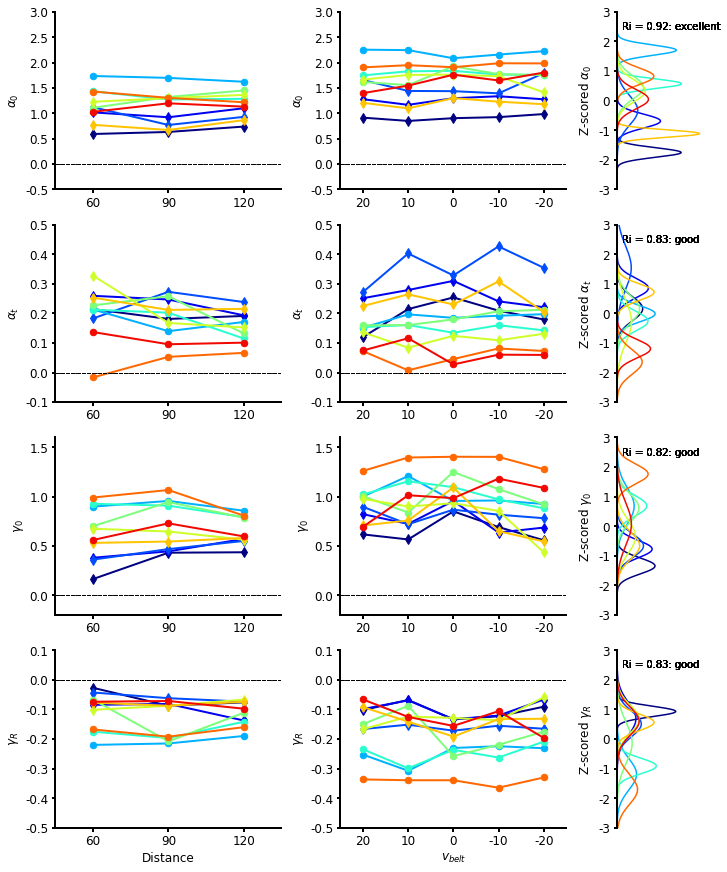

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(10, 12), gridspec_kw={'width_ratios': [5, 5, 2]})
ylabels = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_R$"]
ylims = [[-.5, 3], [-.1, .5], [-.2, 1.6], [-.5, .1]]
alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False

alpha, gamma, alpha_t, gamma_t, alpha_R, gamma_R, lossWald = {}, {}, {}, {}, {}, {}, {}
alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = {}, {}, {}, {}, {}, {}

if os.path.exists("picklejar/idle_time_model_parameters_fit.p"):
    alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, lossWald = pickle.load(open("picklejar/idle_time_model_parameters_fit.p", "rb"))
else:
    if os.path.exists("picklejar/resamplingParameters100ITER.p"):
        alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = pickle.load(open("picklejar/resamplingParameters100ITER.p", "rb"))

    for animal in animalList:
        alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

        for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
            (alpha[animal][cond], theta, gamma[animal][cond], \
            alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
            alpha_R[animal][cond], thetasecond, gamma_R[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                        gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                        alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                        gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                        )

vars = [alpha, alpha_t, gamma, gamma_R]
resampled = [alpha_fit, alpha_t_fit, alpha_R_fit, gamma_fit, gamma_t_fit, gamma_R_fit]
        
for animal in animalList:
    for i, (var, ylabel, ylim, resample) in enumerate(zip(vars, ylabels, ylims, resampled)):
        x, y = np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]]
        axs[i, 0].plot(x, y, color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=6.5, lw=2)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim, resample) in enumerate(zip(vars, ylabels, ylims, resampled)):
        x, y = np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 1].plot(x, y, color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=6.5, lw=2)
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)

axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')


Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in animalList]))/np.std([alpha[animal][key] for animal in animalList]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in animalList]))/np.std([alpha_t[animal][key] for animal in animalList]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in animalList]))/np.std([alpha_R[animal][key] for animal in animalList]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in animalList]))/np.std([gamma[animal][key] for animal in animalList]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in animalList]))/np.std([gamma_t[animal][key] for animal in animalList]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in animalList]))/np.std([gamma_R[animal][key] for animal in animalList]) for key in gamma_R[animal]} for animal in animalList}

traits = {animal: [] for animal in animalList}
Zvars = [Zalpha, Zalpha_t, Zgamma, Zgamma_R]
for j, zvar in enumerate(Zvars):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        pdf = stats.norm.pdf(np.linspace(-3, 3, 600), np.mean(zscores), np.std(zscores))
        traits[animal].append(np.mean(zscores))
        axs[j, 2].plot(pdf, np.linspace(-3, 3, 600), color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
        Ri = compute_Ri(zvar, animalList)
        axs[j, 2].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
        axs[j, 2].set_ylim(-3, 3)
        axs[j, 2].set_xlim(0, 3.5)

        axs[j, 2].set_ylabel("Z-scored " + ylabels[j])
        axs[j, 2].set_xlabel("")
        axs[j, 2].set_xticks([])
        axs[j, 2].spines['bottom'].set_visible(False)


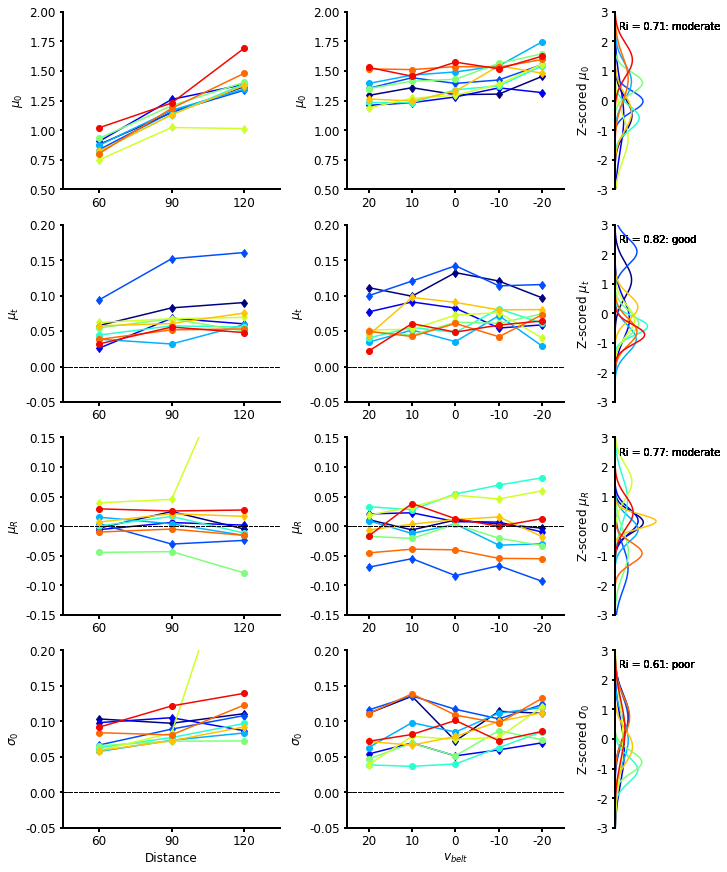

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(10, 12), gridspec_kw={'width_ratios': [5, 5, 2]})
ylabels = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$']
ylims = [[.5, 2], [-.05, .2], [-.15, .15], [-.05, .2]]
mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, False, False, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, True, True, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, False, True, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = True, True, True, True

mu, mu_t, mu_R, sigma, sigma_t, sigma_R, loss = {}, {}, {}, {}, {}, {}, {}
if os.path.exists("picklejar/running_time_model_parameters_fit.p"):
    mu, mu_t, mu_R, sigma, sigma_t, sigma_R, loss = pickle.load(open("picklejar/running_time_model_parameters_fit.p", "rb"))
else:
    for animal in animalList:
        mu[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        loss[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

        for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
            (mu[animal][cond], sigma[animal][cond], \
            mu_t[animal][cond], sigma_t[animal][cond], \
            mu_R[animal][cond], sigma_R[animal][cond]), loss[animal][cond] = modelrun_fit(data[animal], mu_t_fixed=mu_t_fixed, 
                                                                                                                                        sigma_t_fixed=sigma_t_fixed, 
                                                                                                                                        mu_R_fixed=mu_R_fixed, 
                                                                                                                                        sigma_R_fixed=sigma_R_fixed, 
                                                                                                                                        )
vars = [mu, mu_t, mu_R, sigma,]
for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 0].plot(np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 1].plot(np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    
axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')

Zmu = {animal: {key: (mu[animal][key] - np.mean([mu[animal][key] for animal in animalList]))/np.std([mu[animal][key] for animal in animalList]) for key in mu[animal]} for animal in animalList}
Zmu_t = {animal: {key: (mu_t[animal][key] - np.mean([mu_t[animal][key] for animal in animalList]))/np.std([mu_t[animal][key] for animal in animalList]) for key in mu_t[animal]} for animal in animalList}
Zmu_R = {animal: {key: (mu_R[animal][key] - np.mean([mu_R[animal][key] for animal in animalList]))/np.std([mu_R[animal][key] for animal in animalList]) for key in mu_R[animal]} for animal in animalList}
Zsigma = {animal: {key: (sigma[animal][key] - np.mean([sigma[animal][key] for animal in animalList]))/np.std([sigma[animal][key] for animal in animalList]) for key in sigma[animal]} for animal in animalList}
Zsigma_t = {animal: {key: (sigma_t[animal][key] - np.mean([sigma_t[animal][key] for animal in animalList]))/np.std([sigma_t[animal][key] for animal in animalList]) for key in sigma_t[animal]} for animal in animalList}
Zsigma_R = {animal: {key: (sigma_R[animal][key] - np.mean([sigma_R[animal][key] for animal in animalList]))/np.std([sigma_R[animal][key] for animal in animalList]) for key in sigma_R[animal]} for animal in animalList}

traits = {animal: [] for animal in animalList}
Zvars = [Zmu, Zmu_t, Zmu_R, Zsigma]
for j, zvar in enumerate(Zvars):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        pdf = stats.norm.pdf(np.linspace(-3, 3, 600), np.mean(zscores), np.std(zscores))
        traits[animal].append(np.mean(zscores))
        axs[j, 2].plot(pdf, np.linspace(-3, 3, 600), color=rat_markers[animal][0], linestyle=rat_markers[animal][2])
        Ri = compute_Ri(zvar, animalList)
        # print(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}')
        axs[j, 2].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
        axs[j, 2].set_ylim(-3, 3)
        axs[j, 2].set_ylabel("Z-scored " + ylabels[j])
        axs[j, 2].set_xlabel("")
        axs[j, 2].set_xticks([])
        axs[j, 2].set_xlim(0, 3.5)
        axs[j, 2].spines['bottom'].set_visible(False)
# pickle.dump([mu, mu_t, mu_R, sigma, sigma_t, sigma_R, loss], open("picklejar/running_time_model_parameters_fit.p", "wb"))
# pickle.dump(traits, open("picklejar/running_time_model_traits.p", "wb"))

# ri

In [ ]:
def intuition_Ri(gain=0):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    IDs = ["ID1", "ID2", "ID3", "ID4", "ID5", "ID6", "ID7", "ID8"]
    conditions = ['cond1', 'cond2', 'cond3', 'cond4', 'cond5', 'cond6', 'cond7', 'cond8']
    mock = {ID: {k: 0 for k in conditions} for ID in IDs}
    for idx, ID in enumerate(IDs):
        for cond in conditions:
            mock[ID][cond] = np.random.normal(idx*gain, .25)

    Zmock = {ID: {key: (mock[ID][key] - np.mean([mock[ID][key] for ID in IDs]))/np.std([mock[ID][key] for ID in IDs]) for key in mock[ID]} for ID in IDs}


    for c, ID in enumerate(IDs):
        zscores = [Zmock[ID][cond] for cond in conditions]
        axs[0].plot(np.arange(8), zscores, color=plt.cm.get_cmap('jet')(c/8))
        pdf = stats.norm.pdf(np.linspace(-3, 3, 600), np.mean(zscores), np.std(zscores))
        axs[1].plot(pdf, np.linspace(-3, 3, 600), color=plt.cm.get_cmap('jet')(c/8))
        Ri = compute_Ri(Zmock, IDs, conditions)
        axs[1].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
    axs[1].set_ylim(-3, 3)
    axs[0].set_ylim(-3, 3)
    return fig, axs

pl = interact(intuition_Ri, gain=(0, .5, .01))

interactive(children=(FloatSlider(value=0.0, description='gain', max=0.5, step=0.01), Output()), _dom_classes=…

(<Figure size 432x216 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

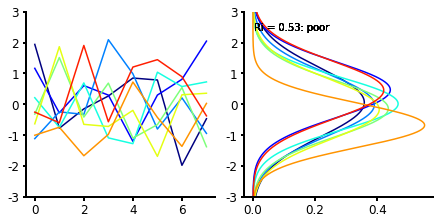

In [ ]:
intuition_Ri(0)

(<Figure size 432x216 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

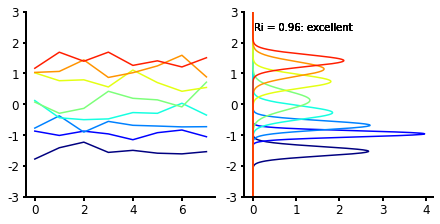

In [ ]:
intuition_Ri(.5)

# cauchy

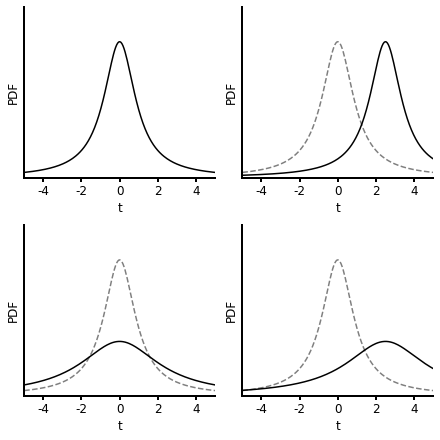

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
x = np.linspace(-5, 50, 1000)
axs[0, 0].plot(x, stats.cauchy.pdf(x, 0, 1), 'k-', label='Default')
axs[0, 1].plot(x, stats.cauchy.pdf(x, 2.5, 1), 'k', label='increased mu')
axs[1, 0].plot(x, stats.cauchy.pdf(x, 0, 2.5), 'k', label='increased sigma')
axs[1, 1].plot(x, stats.cauchy.pdf(x, 2.5, 2.5), 'k', label='increased sigma')

axs[0, 1].plot(x, stats.cauchy.pdf(x, 0, 1), 'k--', alpha=.5, label='Default')
axs[1, 0].plot(x, stats.cauchy.pdf(x, 0, 1), 'k--', alpha=.5, label='Default')
axs[1, 1].plot(x, stats.cauchy.pdf(x, 0, 1), 'k--', alpha=.5, label='Default')

for ax in axs.flatten():
    ax.set_ylim(0, .4)
    ax.set_xlim(-5, 5)
    ax.set_ylabel('PDF')
    ax.set_xlabel('t')
    ax.set_yticks([])



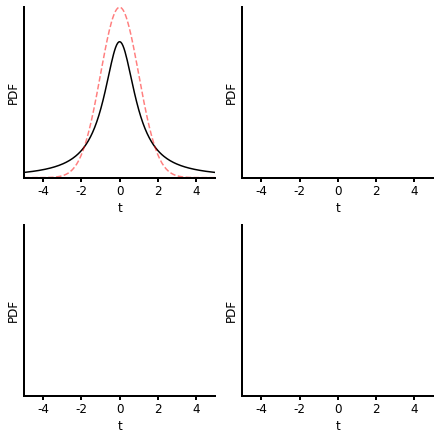

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
x = np.linspace(-5, 50, 1000)
axs[0, 0].plot(x, stats.cauchy.pdf(x, 0, 1), 'k-', label='Default')

axs[0, 0].plot(x, stats.norm.pdf(x, 0, 1), 'r--', alpha=.5, label='Default')

for ax in axs.flatten():
    ax.set_ylim(0, .4)
    ax.set_xlim(-5, 5)
    ax.set_ylabel('PDF')
    ax.set_xlabel('t')
    ax.set_yticks([])

# thcre

In [ ]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 'RatF32', 'RatF33', 'RatM31', 'RatM32']
# THcre RATS
animalList += ['RatF20', 'RatF21', 'RatF22', 'RatM20', 'RatM21', 'RatM22']


_map = plt.cm.get_cmap('jet')

for index, animal in enumerate(animalList):

    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[_map(index/len(animalList)), 'd', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[_map(index/len(animalList)), 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

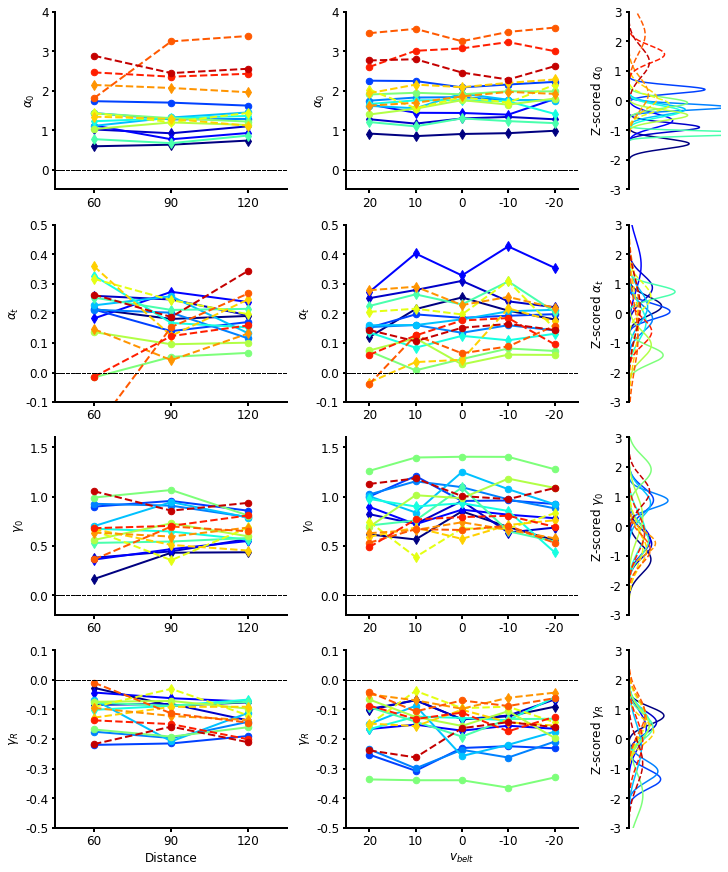

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(10, 12), gridspec_kw={'width_ratios': [5, 5, 2]})
ylabels = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_R$"]
ylims = [[-.5, 4], [-.1, .5], [-.2, 1.6], [-.5, .1]]
alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False

alpha, gamma, alpha_t, gamma_t, alpha_R, gamma_R, lossWald = {}, {}, {}, {}, {}, {}, {}
alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = {}, {}, {}, {}, {}, {}

if os.path.exists("picklejar/idle_time_model_parameters_fit.p"):
    alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, lossWald = pickle.load(open("picklejar/idle_time_model_parameters_fit.p", "rb"))
else:
    if os.path.exists("picklejar/resamplingParameters100ITER.p"):
        alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = pickle.load(open("picklejar/resamplingParameters100ITER.p", "rb"))

    for animal in animalList:
        alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

        for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
            (alpha[animal][cond], theta, gamma[animal][cond], \
            alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
            alpha_R[animal][cond], thetasecond, gamma_R[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                        gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                        alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                        gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                        )

vars = [alpha, alpha_t, gamma, gamma_R]
resampled = [alpha_fit, alpha_t_fit, alpha_R_fit, gamma_fit, gamma_t_fit, gamma_R_fit]
        
for animal in animalList:
    for i, (var, ylabel, ylim, resample) in enumerate(zip(vars, ylabels, ylims, resampled)):
        x, y = np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]]
        axs[i, 0].plot(x, y, color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim, resample) in enumerate(zip(vars, ylabels, ylims, resampled)):
        x, y = np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 1].plot(x, y, color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)

axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')


Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in animalList]))/np.std([alpha[animal][key] for animal in animalList]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in animalList]))/np.std([alpha_t[animal][key] for animal in animalList]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in animalList]))/np.std([alpha_R[animal][key] for animal in animalList]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in animalList]))/np.std([gamma[animal][key] for animal in animalList]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in animalList]))/np.std([gamma_t[animal][key] for animal in animalList]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in animalList]))/np.std([gamma_R[animal][key] for animal in animalList]) for key in gamma_R[animal]} for animal in animalList}

traits = {animal: [] for animal in animalList}
Zvars = [Zalpha, Zalpha_t, Zgamma, Zgamma_R]
for j, zvar in enumerate(Zvars):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        pdf = stats.norm.pdf(np.linspace(-3, 3, 600), np.mean(zscores), np.std(zscores))
        traits[animal].append(np.mean(zscores))
        axs[j, 2].plot(pdf, np.linspace(-3, 3, 600), color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
        Ri = compute_Ri(zvar, animalList)
        # axs[j, 2].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
        axs[j, 2].set_ylim(-3, 3)
        axs[j, 2].set_xlim(0, 3.5)

        axs[j, 2].set_ylabel("Z-scored " + ylabels[j])
        axs[j, 2].set_xlabel("")
        axs[j, 2].set_xticks([])
        axs[j, 2].spines['bottom'].set_visible(False)


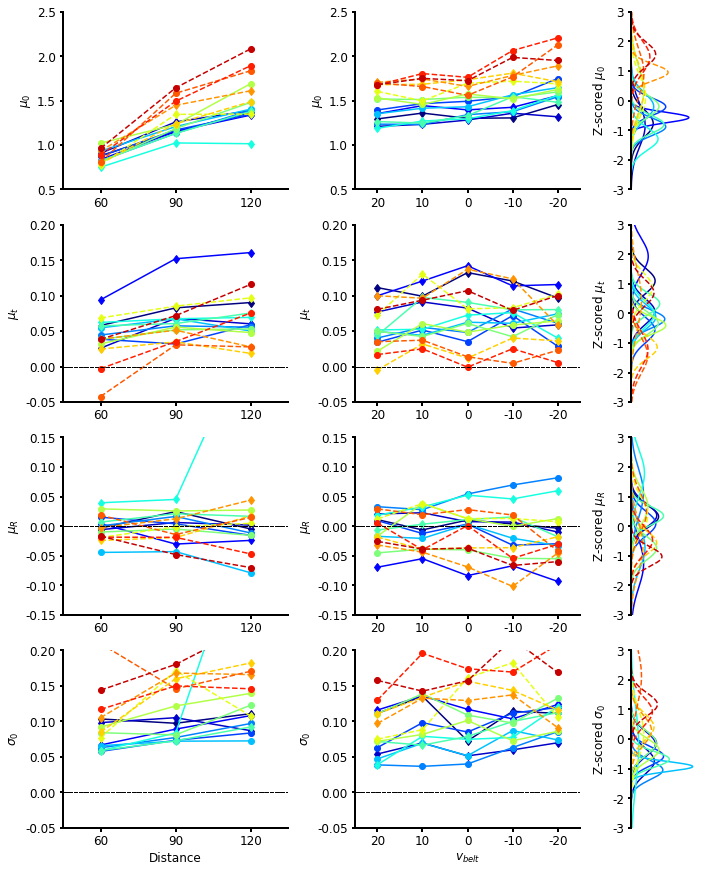

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(10, 12), gridspec_kw={'width_ratios': [5, 5, 2]})
ylabels = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$']
ylims = [[.5, 2.5], [-.05, .2], [-.15, .15], [-.05, .2]]
mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, False, False, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, True, True, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, False, True, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = True, True, True, True

mu, mu_t, mu_R, sigma, sigma_t, sigma_R, loss = {}, {}, {}, {}, {}, {}, {}
if os.path.exists("picklejar/running_time_model_parameters_fit.p"):
    mu, mu_t, mu_R, sigma, sigma_t, sigma_R, loss = pickle.load(open("picklejar/running_time_model_parameters_fit.p", "rb"))
else:
    for animal in animalList:
        mu[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        loss[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

        for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
            (mu[animal][cond], sigma[animal][cond], \
            mu_t[animal][cond], sigma_t[animal][cond], \
            mu_R[animal][cond], sigma_R[animal][cond]), loss[animal][cond] = modelrun_fit(data[animal], mu_t_fixed=mu_t_fixed, 
                                                                                                                                        sigma_t_fixed=sigma_t_fixed, 
                                                                                                                                        mu_R_fixed=mu_R_fixed, 
                                                                                                                                        sigma_R_fixed=sigma_R_fixed, 
                                                                                                                                        )
vars = [mu, mu_t, mu_R, sigma,]
for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 0].plot(np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 1].plot(np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], linestyle=lines[brainstatus[animal]])
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    
axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')

Zmu = {animal: {key: (mu[animal][key] - np.mean([mu[animal][key] for animal in animalList]))/np.std([mu[animal][key] for animal in animalList]) for key in mu[animal]} for animal in animalList}
Zmu_t = {animal: {key: (mu_t[animal][key] - np.mean([mu_t[animal][key] for animal in animalList]))/np.std([mu_t[animal][key] for animal in animalList]) for key in mu_t[animal]} for animal in animalList}
Zmu_R = {animal: {key: (mu_R[animal][key] - np.mean([mu_R[animal][key] for animal in animalList]))/np.std([mu_R[animal][key] for animal in animalList]) for key in mu_R[animal]} for animal in animalList}
Zsigma = {animal: {key: (sigma[animal][key] - np.mean([sigma[animal][key] for animal in animalList]))/np.std([sigma[animal][key] for animal in animalList]) for key in sigma[animal]} for animal in animalList}
Zsigma_t = {animal: {key: (sigma_t[animal][key] - np.mean([sigma_t[animal][key] for animal in animalList]))/np.std([sigma_t[animal][key] for animal in animalList]) for key in sigma_t[animal]} for animal in animalList}
Zsigma_R = {animal: {key: (sigma_R[animal][key] - np.mean([sigma_R[animal][key] for animal in animalList]))/np.std([sigma_R[animal][key] for animal in animalList]) for key in sigma_R[animal]} for animal in animalList}

traits = {animal: [] for animal in animalList}
Zvars = [Zmu, Zmu_t, Zmu_R, Zsigma]
for j, zvar in enumerate(Zvars):
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        pdf = stats.norm.pdf(np.linspace(-3, 3, 600), np.mean(zscores), np.std(zscores))
        traits[animal].append(np.mean(zscores))
        axs[j, 2].plot(pdf, np.linspace(-3, 3, 600), color=rat_markers[animal][0], linestyle=rat_markers[animal][2])
        Ri = compute_Ri(zvar, animalList)
        # print(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}')
        # axs[j, 2].annotate(f'Ri = {Ri:.2f}: {interpret_Ri(Ri)}', xy=(0.05, 0.9), xycoords='axes fraction')
        axs[j, 2].set_ylim(-3, 3)
        axs[j, 2].set_ylabel("Z-scored " + ylabels[j])
        axs[j, 2].set_xlabel("")
        axs[j, 2].set_xticks([])
        axs[j, 2].set_xlim(0, 3.5)
        axs[j, 2].spines['bottom'].set_visible(False)
# pickle.dump([mu, mu_t, mu_R, sigma, sigma_t, sigma_R, loss], open("picklejar/running_time_model_parameters_fit.p", "wb"))
# pickle.dump(traits, open("picklejar/running_time_model_traits.p", "wb"))

# 1 INTRO

In [360]:

# plot session track without analysis files
def plot_animal_trajectory(root, animal, session, params, barplotaxes,
                           xyLabels=["", ""], title=None, ax=None):
    '''
    read position file and plot animal trajectory
    '''
    if ax is None:
        ax = plt.gca()
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    mask = stitch([get_from_pickle(root, animal, session, name="mask.p")])[0]   
    from scipy.ndimage import gaussian_filter as smooth
    pos = smooth(pos.astype('float32'), 2)

    running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(pos, mask)]]
    idle_Xs = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(pos, mask)]]

    for i in range(0, len(params['blocks'])):
        ax.axvspan(params['blocks'][i][0], params['blocks'][i][1],
                    color='grey', alpha=params['rewardProbaBlock'][i]/250,
                    label="%reward: " + str(params['rewardProbaBlock'][i])
                    if (i == 0 or i == 1) else "")

    ax.plot(time, running_Xs, label="run", color="dodgerblue", lw=1)
    ax.plot(time, idle_Xs, label="wait", color="orange", lw=1)

    # ax.set_xlabel(xyLabels[0])
    # ax.set_ylabel(xyLabels[1])
    ax.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax.set_ylim([barplotaxes[2], barplotaxes[3]])
    # ax.set_xticks(np.arange(barplotaxes[0], barplotaxes[1]+1, 300))
    # ax.set_xticklabels(np.arange(0, 61, 5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax



In [361]:

# plot variable median/mean fir each blockFdodger
def plot_median_per_bin(data, rewardProbaBlock, blocks, barplotaxes, color, stat,
                        xyLabels=[" ", " ", " ", " "], title="", scatter=False, ax=None):
    warnings.simplefilter("ignore", category=RuntimeWarning)
    if ax is None:
        ax = plt.gca()

    violin_parts = ax.violinplot(positions=[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                                 dataset=[data[i] for i in range(12)], widths=2.5, showextrema=False)
    for vp in violin_parts['bodies']:
        vp.set_facecolor(color)
        vp.set_edgecolor(color)
        vp.set_linewidth(1)
        vp.set_alpha(0.25)
    
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        try:
            vp = violin_parts[partname]
            vp.set_edgecolor('gray')
            vp.set_linewidth(1)
            vp.set_alpha(0.25)
        except:
            pass


    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, color='grey', alpha=rewardProbaBlock[i]/250, label="%reward: " + str(rewardProbaBlock[i]) if (i == 0 or i == 1) else "")
        if scatter:

            ax.scatter(np.random.normal(((blocks[i][1] + blocks[i][0])/120), 1, len(data[i])), data[i], s=2.5, color=color[0], zorder=3)

    if stat == "Avg. ":
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], [np.mean(data[i]) for i in range(0, len(blocks))], 
                marker='o', ms=7, linewidth=2, color=color[0], zorder=4, markeredgecolor='k', markeredgewidth=0.5)
        # if isinstance(data[0], list):
        #     ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], [np.mean(data[i]) for i in range(0, len(blocks))], yerr=[stats.sem(data[i]) for i in range(0, len(blocks))], fmt='o', color=color[0], ecolor='black', elinewidth=1, capsize=0);

    elif stat == "Med. ":
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], [np.median(data[i]) for i in range(0, len(blocks))], 
                marker='o', ms=7, linewidth=2, color=color[0], zorder=4)
        # if isinstance(data[0], list):
        #     ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], [np.median(data[i]) for i in range(0, len(blocks))], yerr=[stats.sem(data[i]) for i in range(0, len(blocks))], fmt='o', color=color[0], ecolor='black', elinewidth=1, capsize=3);

    ax.set_title(title)
    ax.set_xlabel(xyLabels[0])
    ax.set_ylabel(stat + xyLabels[1], color=color[0])
    ax.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax.set_ylim([barplotaxes[2], barplotaxes[3]])
    # ax.set_yscale('log')
    return ax


def save_plot_as_png(filePath, dpi='figure',
                     transparent=True, background='auto'):
    plt.savefig(filePath, dpi=dpi, transparent=transparent,
                facecolor=background, edgecolor=background)

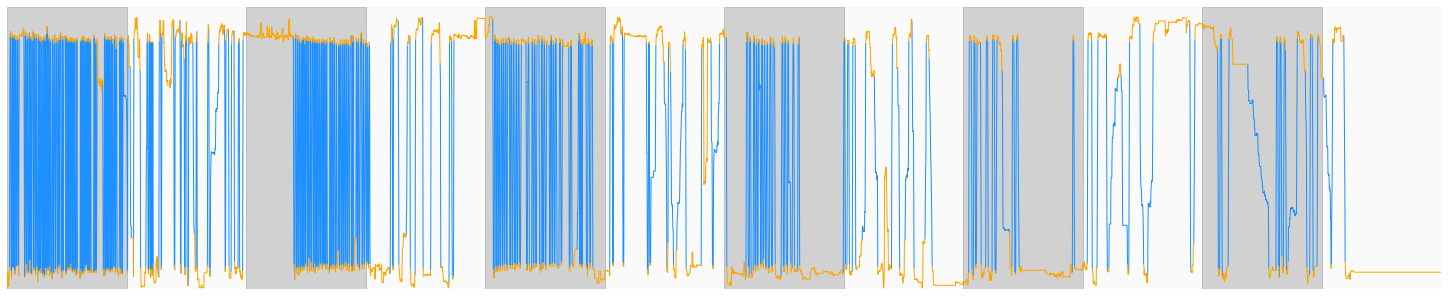

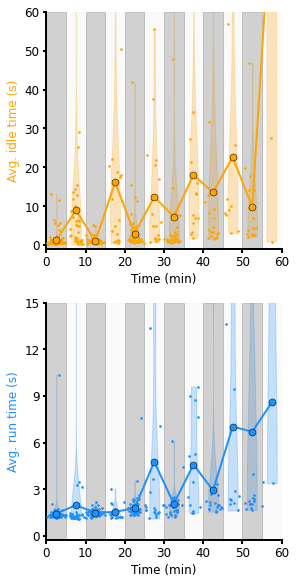

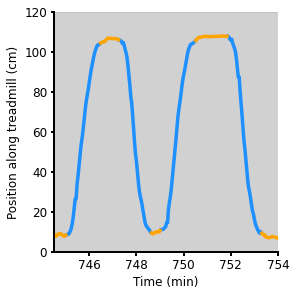

In [371]:

animal, session = 'RatM01', 'RatM01_2021_07_22_17_14_48'  # 'RatF00', 'RatF00_2021_07_24_15_28_05'
animal, session = 'RatF02', 'RatF02_2021_07_22_18_14_16'
example_params = get_from_pickle(root, animal, session, name="params.p")
example_nbRuns = get_from_pickle(root, animal, session, name="nbRuns.p")
example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
example_avgspeedToLeftBin, example_avgspeedToRightBin = get_from_pickle(root, animal, session, name="avgSpeed.p")
example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")



fig, axs = plt.subplots(1, figsize = (20, 4))
# plot the trajectory
plot_animal_trajectory(root=root, animal=animal, session=session, params=example_params, barplotaxes=[0, 3600, 0, 120], 
                 xyLabels=["Time (min)", "Position along treadmill (cm)"], title="Position of example animal across a 120 cm session", ax=axs)

save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/track.png', dpi=300, transparent=True, background='auto')

scat = True
stat ='Avg. '
fig, axs = plt.subplots(2, 1, figsize = (4, 8))

plot_median_per_bin([example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)], 
                example_params['rewardProbaBlock'], example_params['blocks'], barplotaxes=[0, 3600/60, -1, 60], 
                color=['orange'], xyLabels=["Time (min)","idle time (s)"], title="", scatter=scat, stat=stat, ax=axs[0]);

plot_median_per_bin([example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)], 
                example_params['rewardProbaBlock'], example_params['blocks'], barplotaxes=[0, 3600/60, -.25, 15], 
                color=['dodgerblue'], xyLabels=["Time (min)","run time (s)"], title="", scatter=scat, stat=stat, ax=axs[1]);
axs[1].set_yticks([0, 3, 6, 9, 12, 15])

save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/figbin.png', dpi=300, transparent=True, background='auto')



def plot_zoom_trajectory(root, animal, session, params, barplotaxes,
                           xyLabels=["", ""], title=None, ax=None):
    '''
    read position file and plot animal trajectory
    '''
    if ax is None:
        ax = plt.gca()
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    mask = stitch([get_from_pickle(root, animal, session, name="mask.p")])[0]   

    running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(pos, mask)]]
    idle_Xs = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(pos, mask)]]

    for i in range(0, len(params['blocks'])):
        ax.axvspan(params['blocks'][i][0], params['blocks'][i][1],
                    color='grey', alpha=params['rewardProbaBlock'][i]/250,
                    label="%reward: " + str(params['rewardProbaBlock'][i])
                    if (i == 0 or i == 1) else "")

    ax.plot(time, running_Xs, label="run", color="dodgerblue", linewidth=3.5)
    ax.plot(time, idle_Xs, label="wait", color="orange", linewidth=3.5)

    ax.set_xlabel(xyLabels[0])
    ax.set_ylabel(xyLabels[1])
    ax.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax.set_ylim([barplotaxes[2], barplotaxes[3]])
    # ax.set_xticks(np.arange(barplotaxes[0], barplotaxes[1]+1, 300))
    # ax.set_xticklabels(np.arange(0, 61, 5))
    return ax

fig, axs = plt.subplots(1, figsize = (4, 4))
# plot the zoom trajectory
plot_zoom_trajectory(root=root, animal=animal, session=session, params=example_params, barplotaxes=[744.5, 754, 0, 120], 
                 xyLabels=["Time (min)", "Position along treadmill (cm)"], title="Position of example animal across a 120 cm session", ax=axs)


save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/zoom.png', dpi=300, transparent=True, background='auto')


In [363]:
print(42/2.56, 50/2.56)

16.40625 19.53125


# run time 

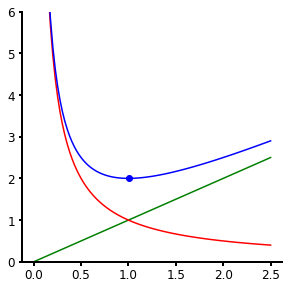

In [408]:
fig, axs = plt.subplots(1, figsize = (10/2.56, 10/2.56))
a=1
effort_sensitivity=1
mass=1
distance=1

T = np.linspace(0, 2.5, 100)
timecost = a*mass*T
axs.plot(T, timecost, color='g')

speedcost = (effort_sensitivity*mass*distance*distance)/T
axs.plot(T, speedcost, color='r')

E_w = timecost + speedcost
axs.plot(T, E_w, color='b')

axs.scatter(T[np.argmin(E_w)], np.min(E_w), color='b')

axs.set_ylim(0, 6)


save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/effortcost.png', dpi=300, transparent=True, background='auto')

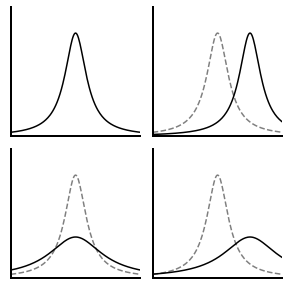

In [398]:
fig, axs = plt.subplots(2, 2, figsize=(10/2.56, 10/2.56))
x = np.linspace(-5, 50, 1000)
axs[0, 0].plot(x, stats.cauchy.pdf(x, 0, 1), 'k-', label='Default')
axs[0, 1].plot(x, stats.cauchy.pdf(x, 2.5, 1), 'k', label='increased mu')
axs[1, 0].plot(x, stats.cauchy.pdf(x, 0, 2.5), 'k', label='increased sigma')
axs[1, 1].plot(x, stats.cauchy.pdf(x, 2.5, 2.5), 'k', label='increased sigma')

axs[0, 1].plot(x, stats.cauchy.pdf(x, 0, 1), 'k--', alpha=.5, label='Default')
axs[1, 0].plot(x, stats.cauchy.pdf(x, 0, 1), 'k--', alpha=.5, label='Default')
axs[1, 1].plot(x, stats.cauchy.pdf(x, 0, 1), 'k--', alpha=.5, label='Default')

for ax in axs.flatten():
    ax.set_ylim(0, .4)
    ax.set_xlim(-5, 5)
    # ax.set_ylabel('PDF')
    # ax.set_xlabel('t')
    ax.set_yticks([])
    ax.set_xticks([])

save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/cauchy.png', dpi=300, transparent=True, background='auto')

# idle

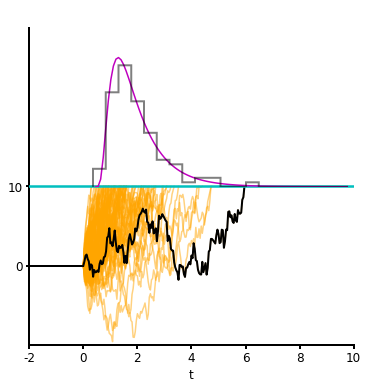

In [402]:
std = 1
t0 = 2
N = 100
def plot_DDMexample2(mean, std, A, t0, N=100, title=''):
    """plot example of DDM with specified parameters"""

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv

        ax.plot(x, y, c='orange', alpha=.5, zorder=3)
    
    # plot the longest element in trials
    longest = np.argmax([len(t) for t in trials])
    x = np.arange(len(trials[longest]))/25
    y = trials[longest]
    ax.plot(x, y, c='k', zorder=4, lw=2)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c='c', zorder=5, lw=2.5)
    ax.set_yticks([0, A])

    ax.set_xlabel('t')

    ax.set_title(title)
    ax.set_ylim(-10, 30)
    ax.set_xlim(-2, 10)
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=2)
    # plt.savefig('DDMparams1.png', transparent=True, dpi=300)


        # inset distribution
    l, b, h, w = 0.105, .55, .5, .85
    ax1 = fig.add_axes([l, b, w, h])
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax1.hist(waits, bins=bins, color='k',
             alpha=.5, zorder=4, histtype="step", lw=2,
             # cumulative=1,
             density=True,
             weights=np.ones_like(waits) / len(waits),
             )
    ax1.set_ylim(0, 0.8)
    ax1.set_xlim(-2, 10)
    ax1.set_ylabel('PDF')
    ax1.axis('off')

    # inset

    # plt.savefig('DDM1.png', transparent=True, dpi=300)



    p, _ = wald_fit(waits)
    x = np.linspace(0, 1000, 10000)
    ax1.plot(x, Wald_pdf(x, *p), 'm-', label='Default')
    # plt.savefig('DDMwald.png', transparent=True, dpi=300)




plot_DDMexample2(.25, std, 10, t0, N=N, title="")
save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/DDM.png', dpi=300, transparent=True, background='auto')

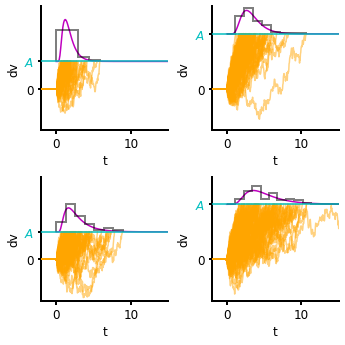

In [403]:
std = 1
t0 = 2
N = 100
def plot_DDMexample2(mean, std, A, t0, N=100, title=''):
    """plot example of DDM with specified parameters"""

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    trials = [generate_trials(mean, std, A, 0) for _ in range(N)]

    example_plot = True
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv

        ax.plot(x, y, c='orange', alpha=.5, zorder=3)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    waitmean = A / mean * np.tanh(mean * A)  #  + t0
    ax.axhline(A, c='c', zorder=5, lw=2.5)
    ax.set_yticks([0, A])

    ax.set_xlabel('t')

    ax.set_title(title)
    ax.set_ylim(-10, 30)
    ax.set_xlim(-2, 10)
    ax.plot((0, -t0), (0, 0), c="k", zorder=5, lw=2)

        # inset distribution
    l, b, h, w = 0.105, .55, .5, .85
    ax1 = fig.add_axes([l, b, w, h])
    mx = 300
    bins = np.arange(0, mx+1, .5)
    ax1.hist(waits, bins=bins, color='k',
             alpha=.5, zorder=4, histtype="step", lw=2,
             # cumulative=1,
             density=True,
             weights=np.ones_like(waits) / len(waits)*25,
             )
    ax1.set_ylim(0, 0.8)
    ax1.set_xlim(-2, 10)
    ax1.set_ylabel('PDF')
    ax1.axis('off')

    p, _ = wald_fit(waits)
    x = np.linspace(0, 1000, 10000)
    ax1.plot(x, 25*Wald_pdf(x, *p)+A, 'm-', label='Default')
    plt.savefig(f'DDM_A{A}_G{mean}.png', transparent=True, dpi=300)

def plot_DDMexampleParams1(v, A, ax=None):
    mean = v
    if ax is None:
        ax = plt.gca()
    N = 100
    t0 = 2
    std = 1
    # np.random.seed(0)
    trials = [generate_trials(mean, std, A, t0) for _ in range(N)]

    rnd = np.random.randint(0, len(trials))
    for dv in trials:
        dv[-1] = A
        x = np.arange(len(dv))/25
        y = dv

        ax.plot(x, y, c='orange', alpha=.5, zorder=3)

    waits = np.array([len(t)/25 for t in trials], dtype=np.float64)

    bins = np.linspace(0, waits.max(), int(max(waits)))
    ax.hist(waits, bins=bins, color='k', bottom=A,
            alpha=.5, zorder=4, histtype="step", lw=2,
            weights=np.ones_like(waits) / len(waits)*25,
            )

    p, _ = wald_fit(waits)
    x = np.linspace(0, 1000, 10000)
    ax.plot(x, (25*Wald_pdf(x, *p))+A, 'm-', label='Default')

    ax.plot((0, -2), (0, 0), c="orange", zorder=5, lw=2)
   
    ax.axhline(A, c='c', zorder=4)
    ax.set_yticks([0, A])
    ax.set_yticklabels([0, r'$A$'])
    ax.get_yticklabels()[1].set_color('c')
    ax.set_xlabel('t')
    ax.set_ylabel('dv')
    ax.set_title('')
    ax.set_ylim(-15, 30)
    ax.set_xlim(-2, 15)



fig, ax = plt.subplots(2, 2, figsize=(12/2.56, 12/2.56))
plot_DDMexampleParams1(.25,  10, ax=ax[0, 0])
plot_DDMexampleParams1(.25,  20, ax=ax[0, 1])
plot_DDMexampleParams1(.15,  10, ax=ax[1, 0])
plot_DDMexampleParams1(.15,  20, ax=ax[1, 1])

save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/DDMparams.png', dpi=300, transparent=True, background='auto')

# explanation 

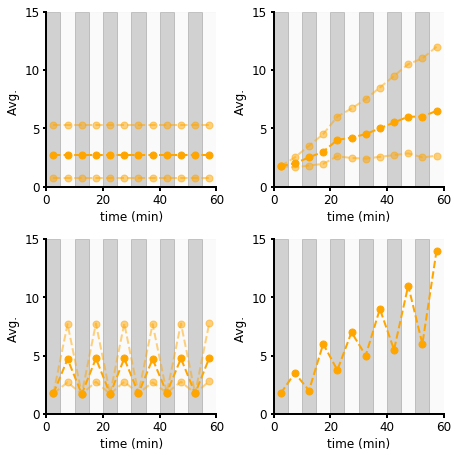

In [438]:
from VIGOR_MODELS_Functions import plot_median_per_bin

fig, axs = plt.subplots(2, 2, figsize=(16/2.56, 16/2.56))
rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

data1 = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
data2 = [1.75, 2, 2.5, 3, 4, 4.2, 4.5, 5, 5.5, 6, 6, 6.5]

data4 = [1.75, 3.5, 2, 6, 3.75, 7, 5, 9, 5.5, 11, 6, 14]

plot_median_per_bin([data1[i]+1 for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15], 
                    color=['orange'], xyLabels=["time (min)",""], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 0]);
axs[0, 0].lines[0].set_linestyle("--")


axs[0, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
        [data1[i]+3.5 for i in range(0, len(blocks))],
        marker='o', ms=7, linewidth=2, color='orange', ls='--', alpha=.5)


axs[0, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
        [data1[i]-1 for i in range(0, len(blocks))],
        marker='o', ms=7, linewidth=2, color='orange', ls='--', alpha=.5)



plot_median_per_bin([data2[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["time (min)",""],
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 1]);
axs[0, 1].lines[0].set_linestyle("--")


axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]+(i*.5) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='orange', ls='--', alpha=.5)
        
axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]-(i*.35) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='orange', ls='--', alpha=.5)




data3 = [1.75, 4.7, 1.7, 4.75, 1.7, 4.75, 1.75, 4.7, 1.80, 4.75, 1.75, 4.80]
plot_median_per_bin([data3[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["time (min)",""],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 0]);
axs[1, 0].lines[0].set_linestyle("--")

data3 = [1.75, 2.7, 1.7, 2.75, 1.7, 2.75, 1.75, 2.7, 1.80, 2.75, 1.75, 2.80]
axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data3[i] for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='orange', ls='--', alpha=.5)


data3 = [1.75, 7.7, 1.7, 7.75, 1.7, 7.75, 1.75, 7.7, 1.80, 7.75, 1.75, 7.80]
axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data3[i] for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='orange', ls='--', alpha=.5)


plot_median_per_bin([data4[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["time (min)",""],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 1]);
axs[1, 1].lines[0].set_linestyle("--")


axs[0, 0].set_yticks([0, 5, 10, 15])
axs[1, 0].set_yticks([0, 5, 10, 15])
axs[0, 1].set_yticks([0, 5, 10, 15])
axs[1, 1].set_yticks([0, 5, 10, 15])


save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/idlemodel.png', dpi=300, transparent=True, background='auto')

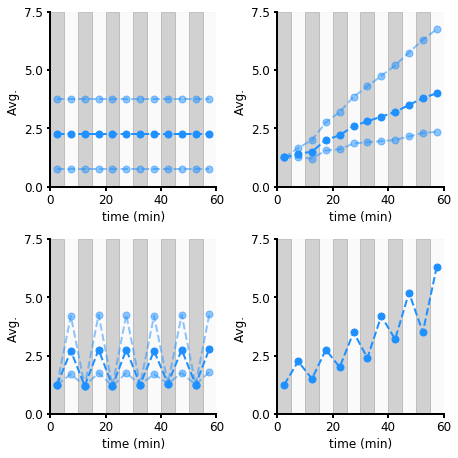

In [439]:
fig, axs = plt.subplots(2, 2, figsize=(16/2.56, 16/2.56))
rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

data1 = [1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, ]
data2 = [1.25, 1.4, 1.5, 2, 2.2, 2.6, 2.8, 3, 3.2, 3.5, 3.8, 4]
# data3 = [6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75, 6.75]
data3 = [1.25, 2.7, 1.2, 2.75, 1.2, 2.75, 1.25, 2.7, 1.30, 2.75, 1.25, 2.80]
data4 = [6.75, 7, 7.5, 8, 9, 9.2, 9.5, 10, 10.5, 11, 11, 11.5]

plot_median_per_bin([data1[i]+1 for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 7.5], 
                    color=['dodgerblue'], xyLabels=["time (min)",""], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 0]);
axs[0, 0].lines[0].set_linestyle("--")


axs[0, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data1[i]+2.5 for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--', alpha=.5)
        
axs[0, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data1[i]-.5 for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--', alpha=.5)



plot_median_per_bin([data2[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 7.5],
                    color=['dodgerblue'], xyLabels=["time (min)",""],
                    title="", scatter=False, stat='Avg. ', ax=axs[0, 1]);
axs[0, 1].lines[0].set_linestyle("--")


axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]+(i*.25) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--', alpha=.5)
        
axs[0, 1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]-(i*.15) for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--', alpha=.5)


        

plot_median_per_bin([data3[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 7.5],
                    color=['dodgerblue'], xyLabels=["time (min)",""],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 0]);
axs[1, 0].lines[0].set_linestyle("--")

data3 = [1.25, 1.7, 1.2, 1.75, 1.2, 1.75, 1.25, 1.7, 1.30, 1.75, 1.25, 1.80]
axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data3[i] for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--', alpha=.5)

data3 = [1.25, 4.2, 1.2, 4.25, 1.2, 4.25, 1.25, 4.2, 1.30, 4.25, 1.25, 4.30]  
axs[1, 0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data3[i] for i in range(0, len(blocks))], 
        marker='o', ms=7, linewidth=2, color='dodgerblue', ls='--', alpha=.5)

data4 = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
plot_median_per_bin([data4[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 7.5],
                    color=['dodgerblue'], xyLabels=["time (min)",""],
                    title="", scatter=False, stat='Avg. ', ax=axs[1, 1]);
axs[1, 1].lines[0].set_linestyle("--")

axs[0, 0].set_yticks([0, 2.5, 5, 7.5])
axs[1, 0].set_yticks([0, 2.5, 5, 7.5])
axs[0, 1].set_yticks([0, 2.5, 5, 7.5])
axs[1, 1].set_yticks([0, 2.5, 5, 7.5])

save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/runmodel.png', dpi=300, transparent=True, background='auto')


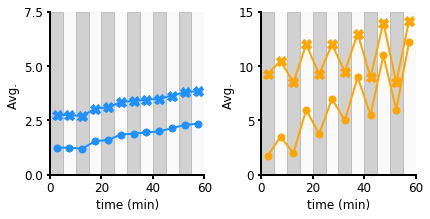

In [56]:
from VIGOR_MODELS_Functions import plot_median_per_bin

fig, axs = plt.subplots(1, 2, figsize=(15/2.56, 7.5/2.56))
rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]


data2 = [1.25, 1.4, 1.5, 2, 2.2, 2.6, 2.8, 3, 3.2, 3.5, 3.8, 4]

plot_median_per_bin([data2[i]-(i*.15) for i in range(0, 12)], 
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 7.5], 
                    color=['dodgerblue'], xyLabels=["time (min)",""], 
                    title="", scatter=False, stat='Avg. ', ax=axs[0]);
# axs[0].lines[0].set_linestyle("--")


axs[0].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
        [data2[i]-(i*.15)+1.5 for i in range(0, len(blocks))],
        marker='X', ms=10, linewidth=2, color='dodgerblue')



# data2 = [1.75, 2, 2.5, 3, 4, 4.2, 4.5, 5, 5.5, 6, 6, 6.5]
data2 = [1.75, 3.5, 2, 6, 3.75, 7, 5, 9, 5.5, 11, 6, 12.2]
plot_median_per_bin([data2[i] for i in range(0, 12)],
                    rewardProbaBlock, blocks, barplotaxes=[0, 60, 0, 15],
                    color=['orange'], xyLabels=["time (min)",""],
                    title="", scatter=False, stat='Avg. ', ax=axs[1]);



axs[1].plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
        [data2[i]+7.5-(i*.5) for i in range(0, len(blocks))], 
        marker='X', ms=10, linewidth=2, color='orange')
        
axs[0].set_yticks([0, 2.5, 5, 7.5])
axs[1].set_yticks([0, 5, 10, 15])


save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/conclusion.png', dpi=300, transparent=True, background='auto')

# 3 MODELS RESULTS

$\alpha_0$: 0.009
$\alpha_t$: 0.003
$\alpha_R$: 0.634
$\gamma_0$: 0.396
$\gamma_t$: 0.834
$\gamma_R$: 0.591
$\mu_0$: 0.0
$\mu_t$: 0.522
$\mu_R$: 0.155
$\sigma_0$: 0.0005
$\sigma_t$: 0.3292
$\sigma_R$: 0.3286


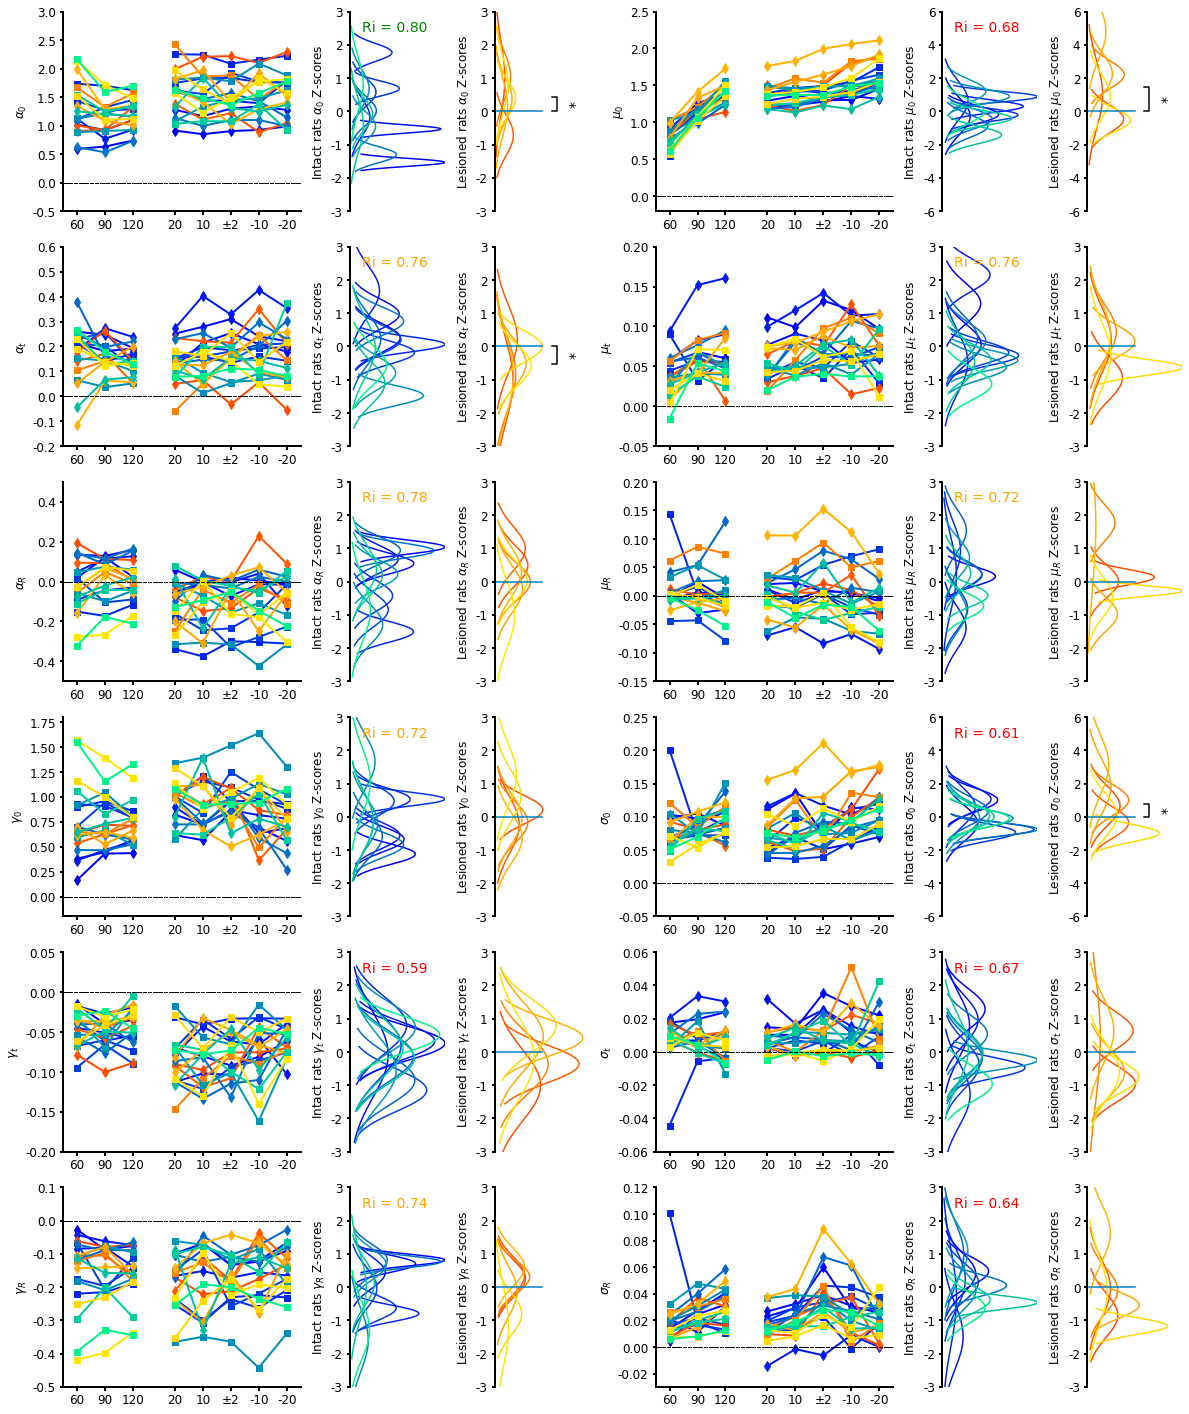

In [50]:
fig, axs = plt.subplots(6, 6, figsize=(42/2.56, 50/2.56), gridspec_kw={'width_ratios': [5, 2, 2, 5, 2, 2]}, constrained_layout=True)
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylimsIDLE = [[-.5, 3], [-.2, .6], [-.5, .5], [-.2, 1.8], [-.2, .05], [-.5, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .2], [-.05, .25], [-.06, .06], [-.03, .12], ]

varsIDLE = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
varsRUN = [mu, mu_t, mu_R, sigma, sigma_t, sigma_R, ]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        # x, y = np.arange(8), [var[animal]["60"], var[animal]["90"], var[animal]["120"], var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].plot([3.5, 4.5, 5.5, 6.5, 7.5], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks([0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5])
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "±2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 8)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 3].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 3].plot([3.5, 4.5, 5.5, 6.5, 7.5], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 3].set_title(f"")
        axs[i, 3].set_xticks([0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5])
        axs[i, 3].set_xticklabels(["60", "90", "120", "20", "10", "±2", "-10", "-20"])
        axs[i, 3].set_ylabel(ylabel)
        axs[i, 3].set_xlim(-.5, 8)
        axs[i, 3].set_ylim(ylim)
        axs[i, 3].axhline(0, color='black', linestyle='--', linewidth=1)
    

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']



Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in intact]))/np.std([alpha[animal][key] for animal in intact]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in intact]))/np.std([alpha_t[animal][key] for animal in intact]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in intact]))/np.std([alpha_R[animal][key] for animal in intact]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in intact]))/np.std([gamma[animal][key] for animal in intact]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in intact]))/np.std([gamma_t[animal][key] for animal in intact]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in intact]))/np.std([gamma_R[animal][key] for animal in intact]) for key in gamma_R[animal]} for animal in animalList}

traitsIDLE = {animal: [] for animal in animalList}
ZvarsIDLE = [Zalpha, Zalpha_t, Zalpha_R, Zgamma, Zgamma_t, Zgamma_R]
for j, zvar in enumerate(ZvarsIDLE):
    xmin, xmax = 0, 0
    ymax = 0
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        xx = np.linspace(stats.norm.ppf(0.02, loc=np.mean(zscores), scale=np.std(zscores)), stats.norm.ppf(.98, loc=np.mean(zscores), scale=np.std(zscores)), 100)
        if min(xx) < xmin:
            xmin = min(xx)
        if max(xx) > xmax:
            xmax = max(xx)
        pdf = stats.norm.pdf(xx, np.mean(zscores), np.std(zscores))
        if max(pdf) > ymax:
            ymax = max(pdf)
        traitsIDLE[animal].append(np.mean(zscores))
        if brainstatus[animal] == "normal":
            axs[j, 1].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allIntact.extend(zscores)
        else:
            axs[j, 2].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allLesion.extend(zscores)
    
    Ri = compute_Ri(zvar, intact)
    axs[j, 1].annotate(f'Ri = {Ri:.2f}', xy=(0.125, 0.9), xycoords='axes fraction', color=Ri_color(Ri), fontsize=14, )

    allIntact = np.array(allIntact).flatten()
    allLesion = np.array(allLesion).flatten()
    perm = exact_mc_perm_test(allIntact, allLesion)
    print(f"{ylabelsIDLE[j]}: {perm:.3f}")
    if perm < 0.05:
        intact_vs_lesion_Zscore(axs[j, 2], 0, 1, perm, 
                                    [0, np.mean([traitsIDLE[animal][j] for animal in animalList if brainstatus[animal] != 'normal'])], 
                                    [ymax/2, ymax/2], yerr=None, dh=ymax/10, barh=ymax/20, fs=14, maxasterix=1)

    # axs[j, 1].set_ylim(xmin, xmax)
    axs[j, 1].set_ylim(-3, 3)
    axs[j, 1].set_xlim(0, ymax)
    axs[j, 1].set_ylabel(f"Intact rats {ylabelsIDLE[j]} Z-scores")
    axs[j, 1].set_xlabel("")
    axs[j, 1].set_xticks([])
    axs[j, 1].spines['bottom'].set_visible(False)
    axs[j, 2].set_ylim(xmin, xmax)
    axs[j, 2].plot([0, ymax/2], [0, 0], c=plt.cm.get_cmap('winter')(.5))
    axs[j, 2].set_ylim(-3, 3)
    axs[j, 2].set_xlim(0, ymax)
    axs[j, 2].set_ylabel(f"Lesioned rats {ylabelsIDLE[j]} Z-scores")
    axs[j, 2].set_xlabel("")
    axs[j, 2].set_xticks([])
    axs[j, 2].spines['bottom'].set_visible(False)



Zmu = {animal: {key: (mu[animal][key] - np.mean([mu[animal][key] for animal in intact]))/np.std([mu[animal][key] for animal in intact]) for key in mu[animal]} for animal in animalList}
Zmu_t = {animal: {key: (mu_t[animal][key] - np.mean([mu_t[animal][key] for animal in intact]))/np.std([mu_t[animal][key] for animal in intact]) for key in mu_t[animal]} for animal in animalList}
Zmu_R = {animal: {key: (mu_R[animal][key] - np.mean([mu_R[animal][key] for animal in intact]))/np.std([mu_R[animal][key] for animal in intact]) for key in mu_R[animal]} for animal in animalList}
Zsigma = {animal: {key: (sigma[animal][key] - np.mean([sigma[animal][key] for animal in intact]))/np.std([sigma[animal][key] for animal in intact]) for key in sigma[animal]} for animal in animalList}
Zsigma_t = {animal: {key: (sigma_t[animal][key] - np.mean([sigma_t[animal][key] for animal in intact]))/np.std([sigma_t[animal][key] for animal in intact]) for key in sigma_t[animal]} for animal in animalList}
Zsigma_R = {animal: {key: (sigma_R[animal][key] - np.mean([sigma_R[animal][key] for animal in intact]))/np.std([sigma_R[animal][key] for animal in intact]) for key in sigma_R[animal]} for animal in animalList}

traitsRUN = {animal: [] for animal in animalList}
ZvarsRUN = [Zmu, Zmu_t, Zmu_R, Zsigma, Zsigma_t, Zsigma_R]
for j, zvar in enumerate(ZvarsRUN):
    xmin, xmax = 0, 0
    ymax = 0
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        xx = np.linspace(stats.norm.ppf(0.02, loc=np.mean(zscores), scale=np.std(zscores)), stats.norm.ppf(.98, loc=np.mean(zscores), scale=np.std(zscores)), 100)
        if min(xx) < xmin:
            xmin = min(xx)
        if max(xx) > xmax:
            xmax = max(xx)
        pdf = stats.norm.pdf(xx, np.mean(zscores), np.std(zscores))
        if max(pdf) > ymax:
            ymax = max(pdf)
        traitsRUN[animal].append(np.mean(zscores))

        if brainstatus[animal] == "normal":
            axs[j, 4].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allIntact.extend(zscores)
        else:
            axs[j, 5].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allLesion.extend(zscores)
    
    Ri = compute_Ri(zvar, intact)
    axs[j, 4].annotate(f'Ri = {Ri:.2f}', xy=(0.125, 0.9), xycoords='axes fraction', color=Ri_color(Ri), fontsize=14, )

    allIntact = np.array(allIntact).flatten()
    allLesion = np.array(allLesion).flatten()
    perm = exact_mc_perm_test(allIntact, allLesion)
    print(f"{ylabelsRUN[j]}: {perm}")
    if perm < 0.05:
        intact_vs_lesion_Zscore(axs[j, 5], 0, 1, perm, 
                                    [0, np.mean([traitsRUN[animal][j] for animal in animalList if brainstatus[animal] != 'normal'])], 
                                    [ymax/2, ymax/2], yerr=None, dh=ymax/10, barh=ymax/20, fs=14, maxasterix=1)



    # axs[j, 4].set_ylim(xmin, xmax)
    axs[j, 4].set_ylim(-3, 3)
    axs[j, 4].set_xlim(0, ymax)

    axs[j, 4].set_ylabel(f"Intact rats {ylabelsRUN[j]} Z-scores")
    axs[j, 4].set_xlabel("")
    axs[j, 4].set_xticks([])
    axs[j, 4].spines['bottom'].set_visible(False)
    # axs[j, 5].set_ylim(xmin, xmax)
    axs[j, 5].set_ylim(-3, 3)
    axs[j, 5].set_xlim(0, ymax)
    axs[j, 5].plot([0, ymax/2], [0, 0], c=plt.cm.get_cmap('winter')(.5))
    axs[j, 5].set_ylabel(f"Lesioned rats {ylabelsRUN[j]} Z-scores")
    axs[j, 5].set_xlabel("")
    axs[j, 5].set_xticks([])
    axs[j, 5].spines['bottom'].set_visible(False)


axs[0, 4].set_ylim(-6, 6)
axs[0, 5].set_ylim(-6, 6)

axs[3, 4].set_ylim(-6, 6)
axs[3, 5].set_ylim(-6, 6)

save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/FitVariaComp.png', dpi=300, transparent=True, background='auto')

idle 0 0.0095 -1.4354836763708079e-16 0.4278378197172869
idle 1 0.0029 -6.271692566993072e-17 -0.5175263426341465
idle 2 0.6302 -3.255942524141084e-17 0.07896507411591355
idle 3 0.3916 -4.8171936525202106e-17 0.14018649797744437
idle 4 0.8298 7.018958064336927e-17 -0.03687030047414768
idle 5 0.588 -1.235656875965018e-16 -0.09103527514908642
run 0 0.0 6.268022959640044e-16 1.448584332913132
run 1 0.5019 4.697097411875662e-17 -0.1079337719848774
run 2 0.1584 1.4411548877345783e-17 0.263686926838833
run 3 0.0007 2.568725147119503e-18 0.7663195628478979
run 4 0.3295 -1.521219048164277e-17 -0.17786334102356519
run 5 0.3352 2.5887411872269276e-17 -0.16774891347685655


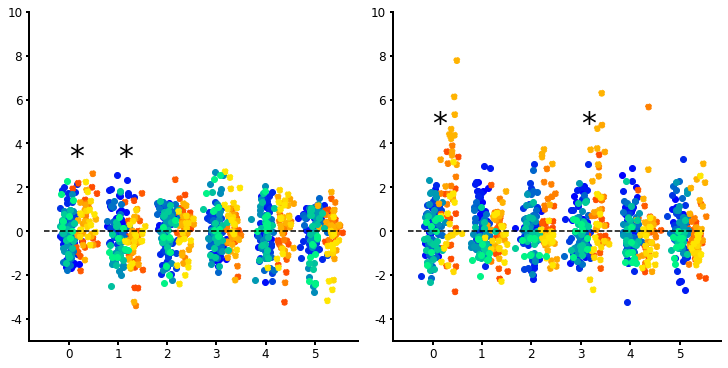

In [345]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), )

axs[0].set_ylim(-5, 10)
axs[1].set_ylim(-5, 10)
axs[0].plot([-.5, 5.5], [0, 0], color='black', linestyle='--')
axs[1].plot([-.5, 5.5], [0, 0], color='black', linestyle='--')

for j, zvar in enumerate(ZvarsIDLE):
    allIntact = []
    allLesion = []
    for animal in animalList:
        
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        # print(animal, zscores)
        if brainstatus[animal] == "normal":
            allIntact.extend(zscores)
            shift=0
        else:
            allLesion.extend(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[0].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
    
    perm = exact_mc_perm_test(allIntact, allLesion)
    print("idle", j, perm, np.mean(allIntact), np.mean(allLesion))
    if perm < 0.05:
        axs[0].annotate("*", xy=(j, 3), xycoords='data', fontsize=30)

for j, zvar in enumerate(ZvarsRUN):
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        if brainstatus[animal] == "normal":
            allIntact.append(zscores)
            shift=0
        else:
            allLesion.append(zscores)
            shift=0.35
        x = j+shift+np.random.normal(0, 0.1, len(zscores))
        axs[1].scatter(x, zscores, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])

    allIntact = np.array(allIntact).flatten()
    allLesion = np.array(allLesion).flatten()
    perm = exact_mc_perm_test(allIntact, allLesion)
    print("run", j, perm, np.mean(allIntact), np.mean(allLesion))
    if perm < 0.05:
        axs[1].annotate("*", xy=(j, 4.5), xycoords='data', fontsize=30)


$\alpha_0$ corr: 0.43, p: 0.0604
$\alpha_t$ corr: -0.42, p: 0.0649
$\alpha_R$ corr: -0.64, p: 0.0025
$\gamma_0$ corr: 0.69, p: 0.0008
$\gamma_t$ corr: 0.09, p: 0.7137
$\gamma_R$ corr: -0.60, p: 0.0050
$\mu_0$ corr: -0.02, p: 0.9201
$\mu_t$ corr: -0.52, p: 0.0190
$\mu_R$ corr: 0.02, p: 0.9453
$\sigma_0$ corr: -0.47, p: 0.0365
$\sigma_t$ corr: -0.42, p: 0.0627
$\sigma_R$ corr: 0.07, p: 0.7625


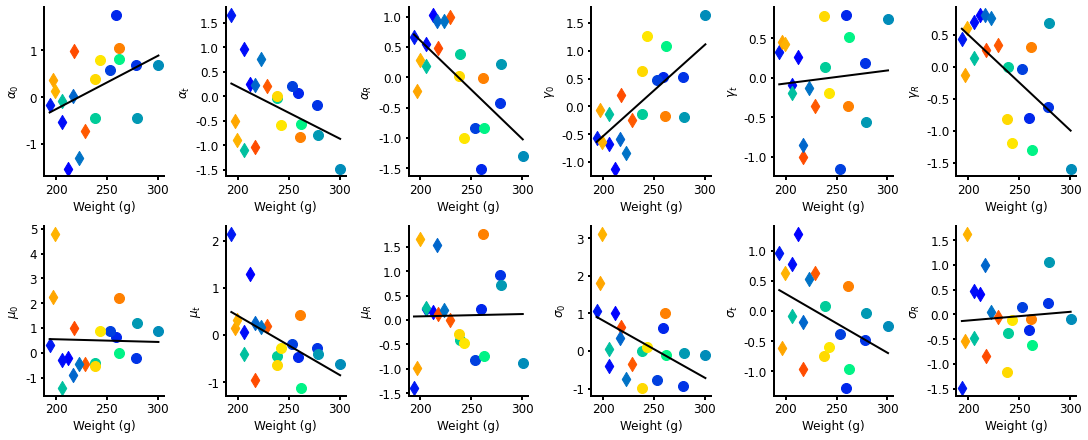

In [348]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            # 'RatF20': 220.10, 'RatF21': 215.53, 'RatF22': 215.0,
            # 'RatM20': 254.68, 'RatM21': 307.29, 'RatM22': 330.53,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            # 'RatF30L': 217.32, 'RatF31L': 228.95, 'RatF32L': 216.80, 'RatF33L': 222.77,
            # 'RatM30L': 261.38, 'RatM31L': 300.55, 'RatM32L': 279.23
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}

fig, ax = plt.subplots(2, 6, figsize=(15, 6))
for j in range(6):
    _x, _y = [], []
    for animal in animalList:
        y = traitsIDLE[animal][j]
        x = weights[animal]

        ax[0, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[0, j].set_xlabel("Weight (g)")
        ax[0, j].set_ylabel(ylabelsIDLE[j])
        # ax[0, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsIDLE[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[0, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

for j in range(6):
    _x, _y = [], []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = traitsRUN[animal][j]
        x = weights[animal]

        ax[1, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[1, j].set_xlabel("Weight (g)")
        ax[1, j].set_ylabel(ylabelsRUN[j])
        # ax[1, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsRUN[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[1, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)